# Comparison of the custom back tester with BackTrader
Let's implement the logic of the selected configuration of the strategy using BackTrader API https://backtrader.com. It will help us to verify the results of backtesting.

In [5]:
import sys
sys.path.append('../')

from Strategy import Strategy
import backtrader as bt
import os
import numpy as np
from datetime import datetime
from pandas import Series
import matplotlib.pyplot as plt
from tools import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

## Run custom back tester over first 500 periods

In [6]:
bars_data = load_ohlc_data('../data/binance_1h')
prices_data = get_bar_value_for_all_tickers(bars_data, 'close')

final_strategy = LongShortTradingStrategy(prices_data.head(500), benchmark_ticker='BTCUSDT')
final_strategy.set_strategy_params(up_q=0.07, down_q=0.07, max_t_in_pos=1)
final_strategy.run(log_trades=True)

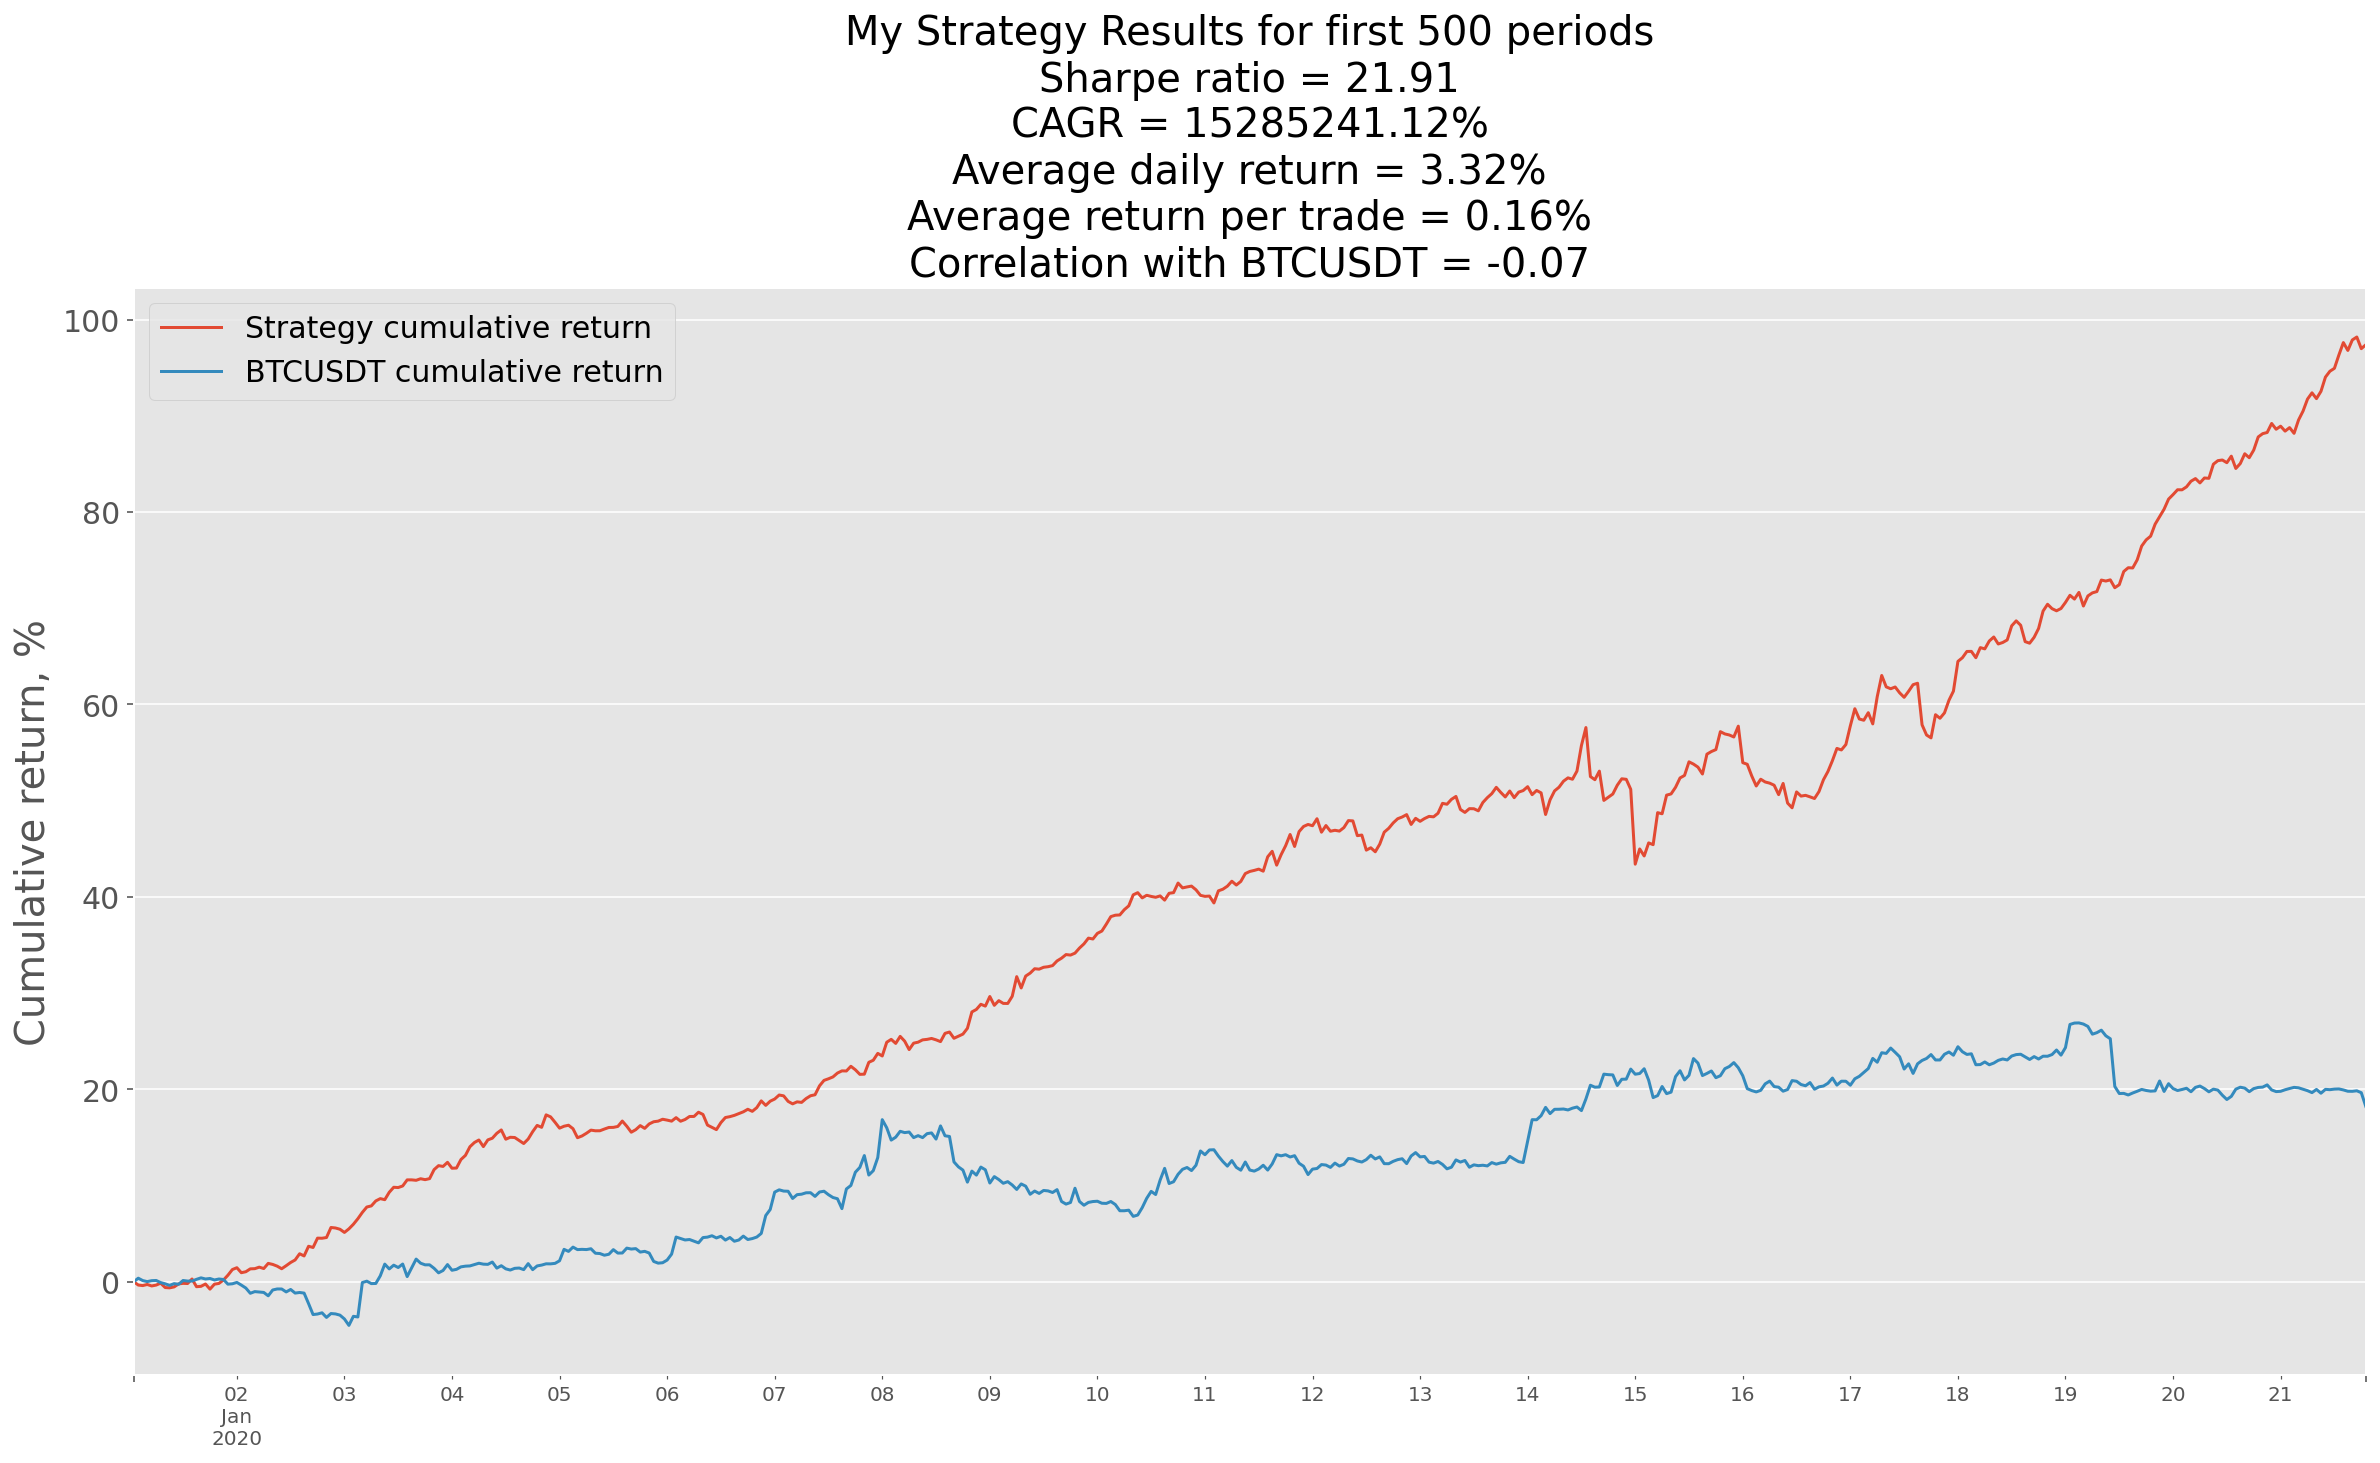

In [3]:
plot_strategy_results(final_strategy, 'My Strategy Results for first 500 periods')

## Run BackTrader on the same period

In [49]:
cerebro = bt.Cerebro()

# CSV files are processed to have explicit NaNs because BackTrader uses inner join logic for multiple dataframes
folder_path = 'binance_1h_processed'
for file_name in os.listdir(folder_path):
    ticker = file_name[:file_name.index('.')]
    data = bt.feeds.GenericCSVData(dataname=os.path.join(folder_path, file_name),
                                   name=ticker,
                                   nullvalue=np.nan,
                                   fromdate=datetime(2020, 1, 1, 0),
                                   todate=datetime(2020, 1, 21, 19),
                                   dtformat=('%Y-%m-%d %H:%M:%S'),
                                   timeframe=bt.TimeFrame.Minutes,
                                   compression=60,
                                   datetime=0,
                                   open=1,
                                   high=2,
                                   low=3,
                                   close=4,
                                   volume=5,
                                   time=-1,
                                   openinterest=-1)
    cerebro.adddata(data)

cerebro.addstrategy(Strategy)
cerebro.getbroker().setcash(1000000)
# cheat-on-close allows to open positions using current close price
cerebro.getbroker().set_coc(True)
# shortcash = False means that shorted cash is taken into account and substracted when a short position is opened
cerebro.getbroker().set_shortcash(False)
# checksubmit = False means that we don't check order for available amount of cache before they are executed
# Let's use this setting to reproduce custom backtesting results
# Then we will check whether we borrow smth or not using Gross Leverage indicator
cerebro.getbroker().set_checksubmit(False)

cerebro.addanalyzer(bt.analyzers.PyFolio)
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')

res = cerebro.run(cheat_on_close=True, preloaded=False)
returns1d, positions, transactions, gross_lev = res[0].analyzers.getbyname('pyfolio').get_pf_items()
returns1h = res[0].analyzers.getbyname('timereturn').get_analysis()

2020-01-01 01:00:00 1000000.0
2020-01-01 02:00:00 996543.613024
2020-01-01 03:00:00 995994.8095377
2020-01-01 04:00:00 997138.442759
2020-01-01 05:00:00 995608.475929
2020-01-01 06:00:00 996524.6792169999
2020-01-01 07:00:00 998492.3747569999
2020-01-01 08:00:00 993947.330317
2020-01-01 09:00:00 993645.126747
2020-01-01 10:00:00 994605.8170470002
2020-01-01 11:00:00 997746.1578310003
2020-01-01 12:00:00 998324.5840560003
2020-01-01 13:00:00 998132.7593272005
2020-01-01 14:00:00 1002824.7273272005
2020-01-01 15:00:00 994823.9705472004
2020-01-01 16:00:00 995215.9437072001
2020-01-01 17:00:00 997648.1427672005
2020-01-01 18:00:00 992304.9695072004
2020-01-01 19:00:00 997458.4120372004
2020-01-01 20:00:00 998223.0115052005
2020-01-01 21:00:00 1001752.7909892005
2020-01-01 22:00:00 1006745.2285412005
2020-01-01 23:00:00 1012677.5437812005
2020-01-02 00:00:00 1014567.9651712005
2020-01-02 01:00:00 1009368.6595032004
2020-01-02 02:00:00 1010393.2628332006
2020-01-02 03:00:00 1013382.13478200

2020-01-10 04:00:00 1381372.3407113007
2020-01-10 05:00:00 1381629.0286673005
2020-01-10 06:00:00 1387095.2750473002
2020-01-10 07:00:00 1391112.5544323004
2020-01-10 08:00:00 1402563.2921123
2020-01-10 09:00:00 1404803.9125523004
2020-01-10 10:00:00 1399376.825073101
2020-01-10 11:00:00 1402081.4589078007
2020-01-10 12:00:00 1400906.901924101
2020-01-10 13:00:00 1400013.9476953007
2020-01-10 14:00:00 1401449.6304863007
2020-01-10 15:00:00 1397066.099303501
2020-01-10 16:00:00 1404153.607093501
2020-01-10 17:00:00 1404859.7367995013
2020-01-10 18:00:00 1414806.8639115014
2020-01-10 19:00:00 1409771.5796005016
2020-01-10 20:00:00 1410769.2147505018
2020-01-10 21:00:00 1411644.313962902
2020-01-10 22:00:00 1407789.2047429015
2020-01-10 23:00:00 1402014.034602901
2020-01-11 00:00:00 1400976.8558269017
2020-01-11 01:00:00 1401275.1388069014
2020-01-11 02:00:00 1394110.8159569013
2020-01-11 03:00:00 1406711.3220779013
2020-01-11 04:00:00 1408424.064797901
2020-01-11 05:00:00 1411566.9898011

2020-01-19 07:00:00 1718072.139199201
2020-01-19 08:00:00 1730032.0699930012
2020-01-19 09:00:00 1729010.9518920009
2020-01-19 10:00:00 1730248.622334001
2020-01-19 11:00:00 1722085.0323646003
2020-01-19 12:00:00 1725191.2121260003
2020-01-19 13:00:00 1738921.1548340004
2020-01-19 14:00:00 1742864.1516520004
2020-01-19 15:00:00 1742612.4934995007
2020-01-19 16:00:00 1751047.2230015
2020-01-19 17:00:00 1765406.4636385
2020-01-19 18:00:00 1771827.8013185004
2020-01-19 19:00:00 1775683.4788555007
2020-01-19 20:00:00 1788147.3259115007
2020-01-19 21:00:00 1795973.4289335003
2020-01-19 22:00:00 1803745.2362999003
2020-01-19 23:00:00 1814202.4013099
2020-01-20 00:00:00 1818896.7495699006
2020-01-20 01:00:00 1823935.4109419
2020-01-20 02:00:00 1823870.5888419002
2020-01-20 03:00:00 1826938.6473128998
2020-01-20 04:00:00 1832788.5655328997
2020-01-20 05:00:00 1835559.9764378997
2020-01-20 06:00:00 1831059.9827207003
2020-01-20 07:00:00 1836174.1013806998
2020-01-20 08:00:00 1835828.0156887001


### The results are exactly the same!
### And Gross Leverage <= 1 for the whole period. Along with setting that takes shorted cash into account it means that we do not use extra leverage to open positions.

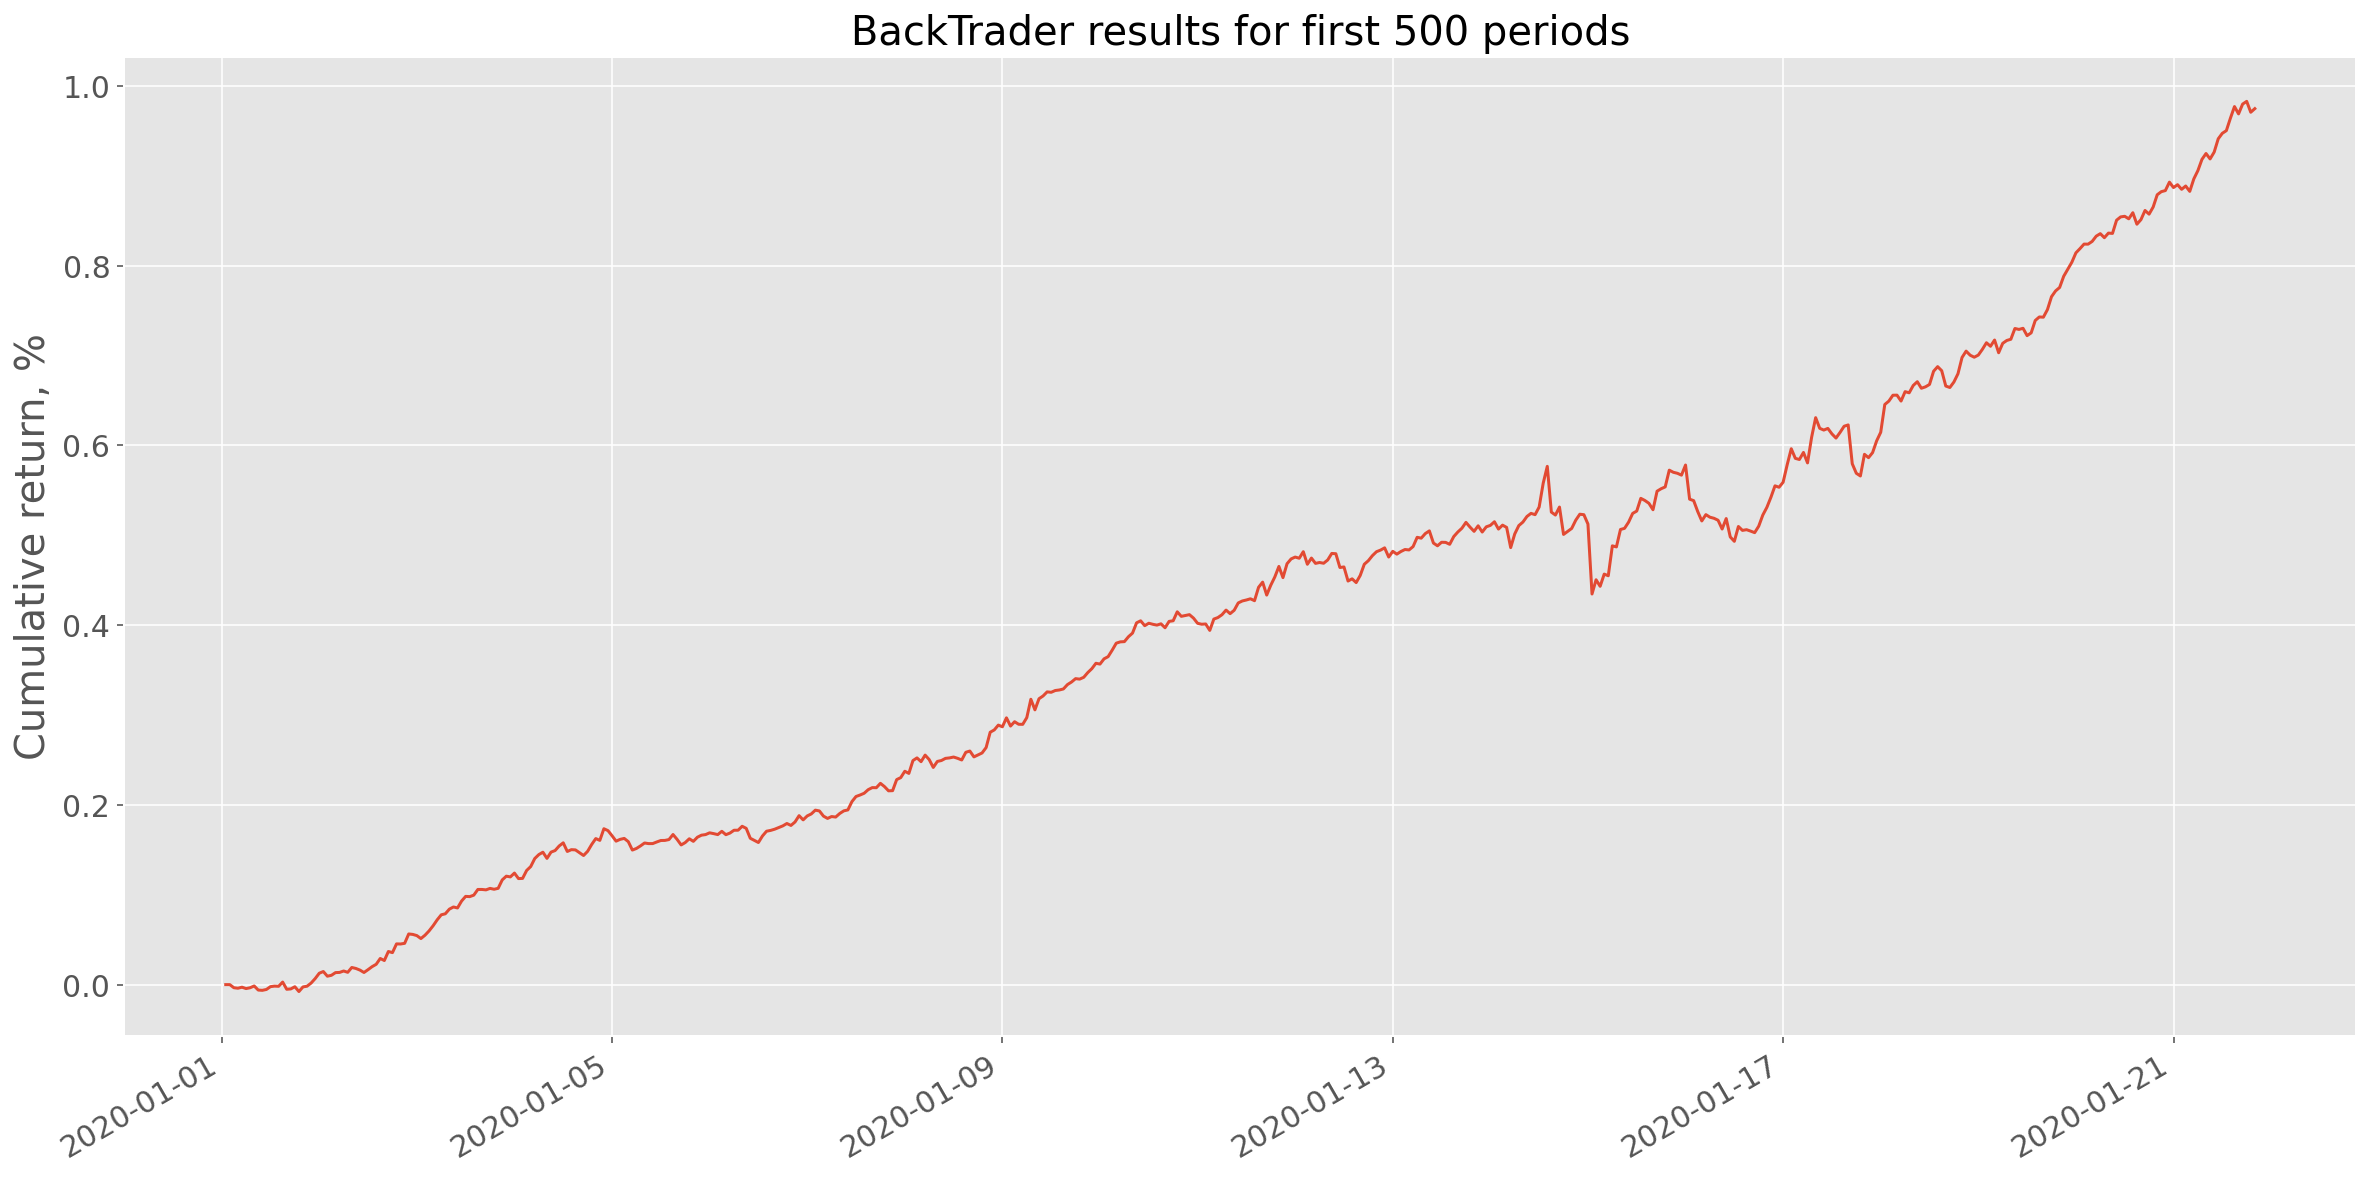

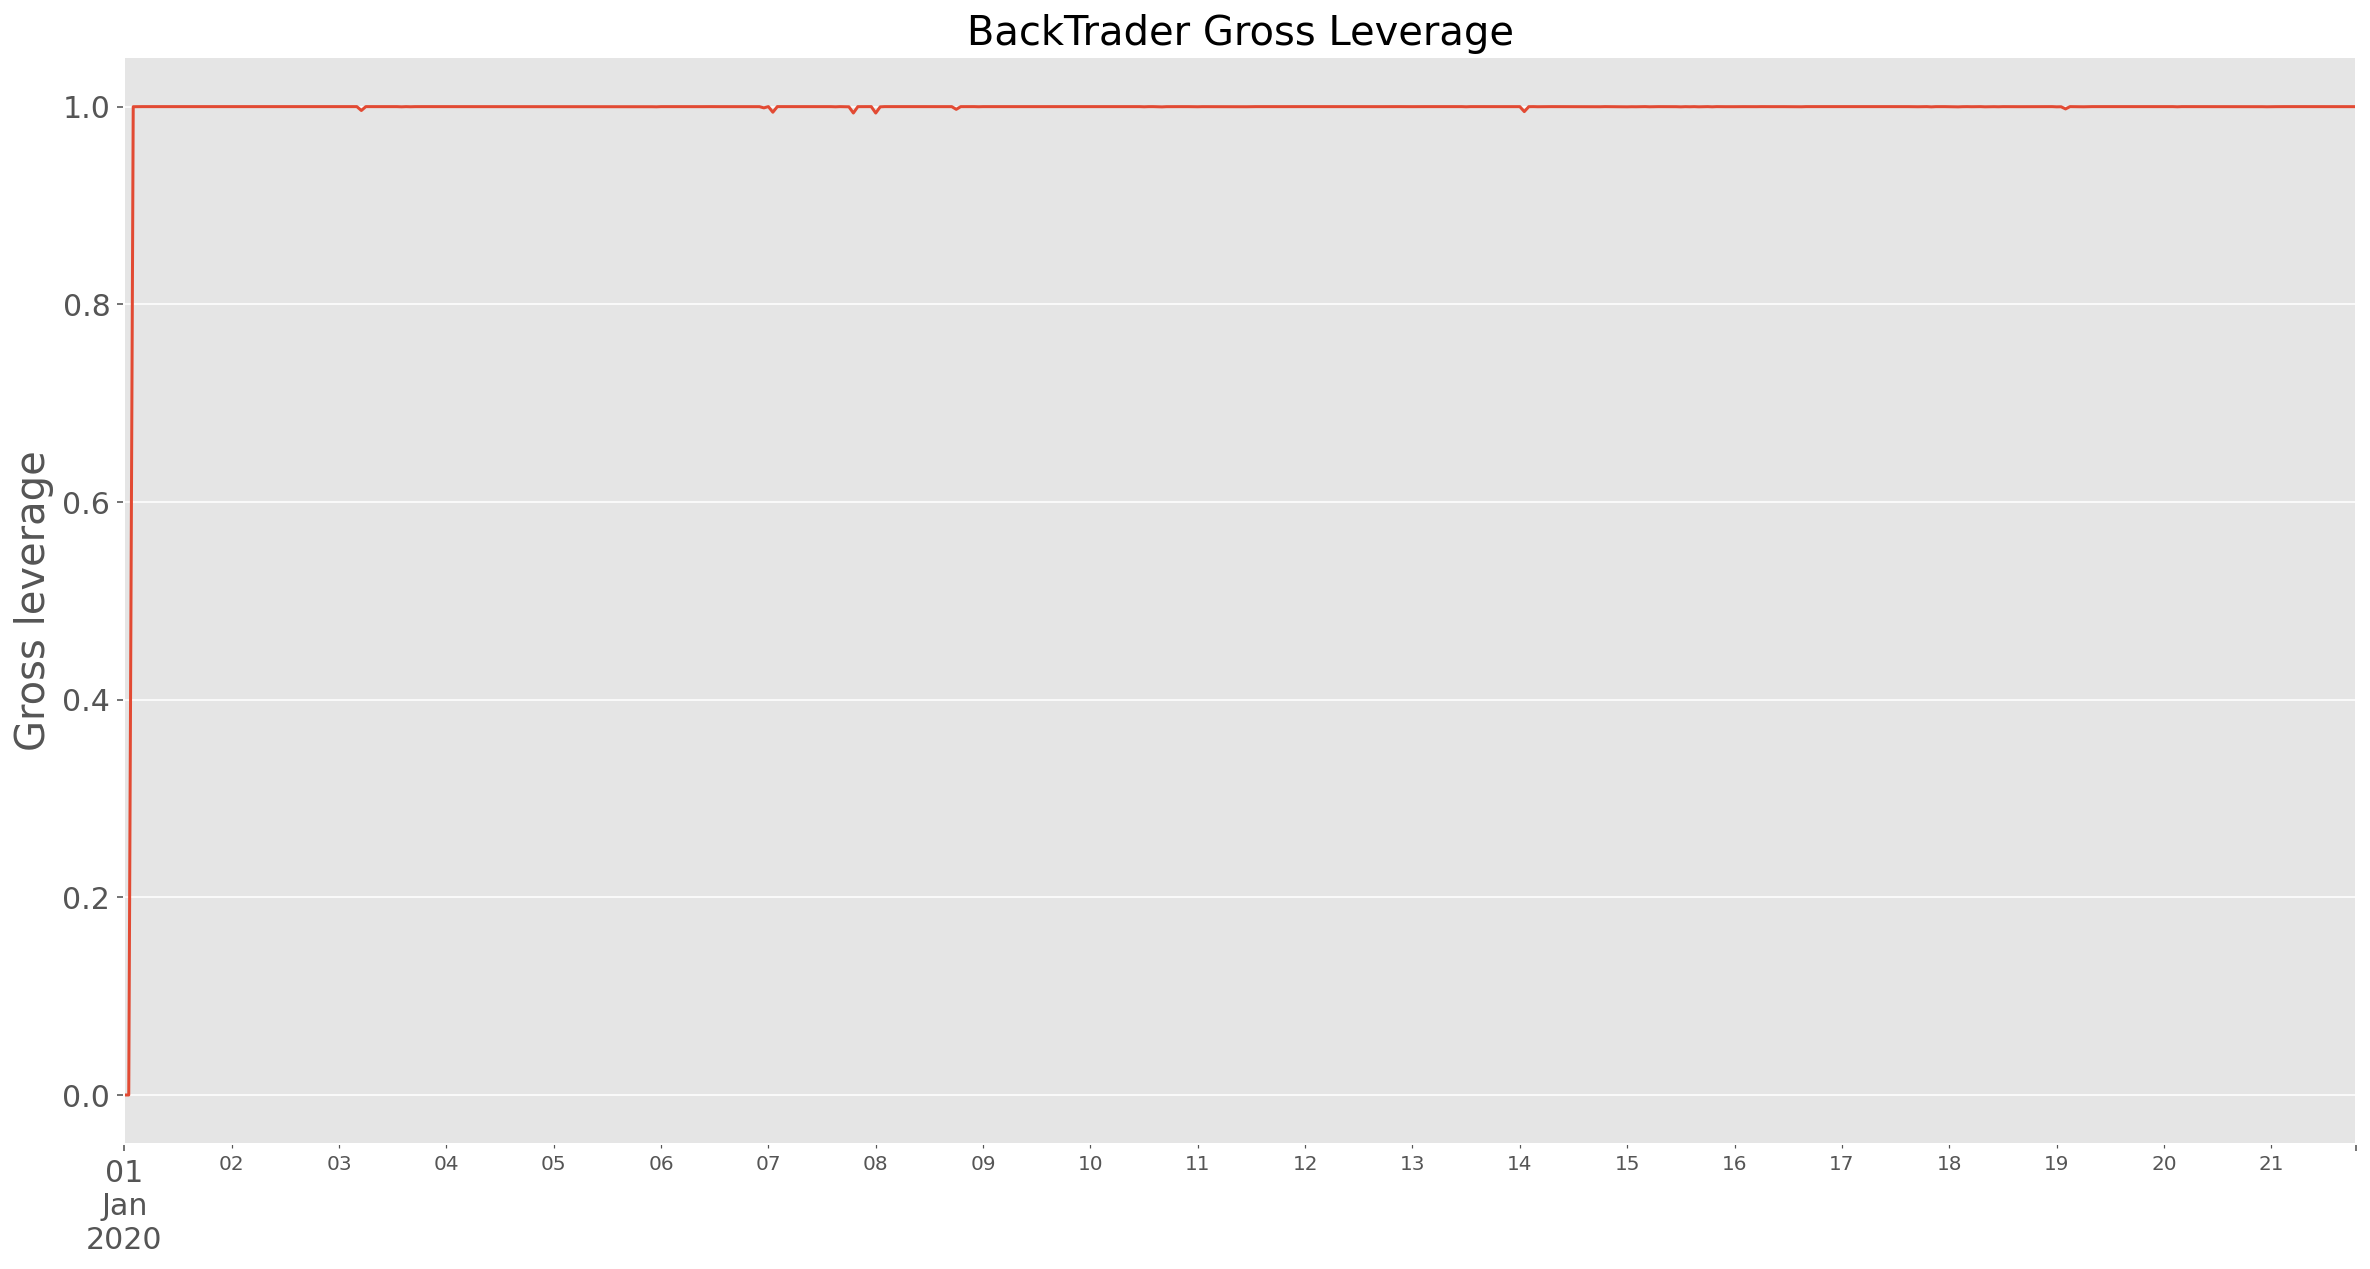

In [51]:
bt_cum_ret = (np.cumproduct(Series(returns1h) + 1) - 1)
bt_cum_ret.plot(figsize=(20, 10))
plt.xlabel('')
plt.ylabel('Cumulative return, %', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('BackTrader results for first 500 periods', size=20)
plt.show()

gross_lev.plot(figsize=(20, 10))
plt.xlabel('')
plt.ylabel('Gross leverage', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('BackTrader Gross Leverage', size=20)
plt.show()

## Run custom back tester over the whole sample

In [4]:
final_strategy = LongShortTradingStrategy(prices_data, benchmark_ticker='BTCUSDT')
final_strategy.set_strategy_params(up_q=0.07, down_q=0.07, max_t_in_pos=1)
final_strategy.run()

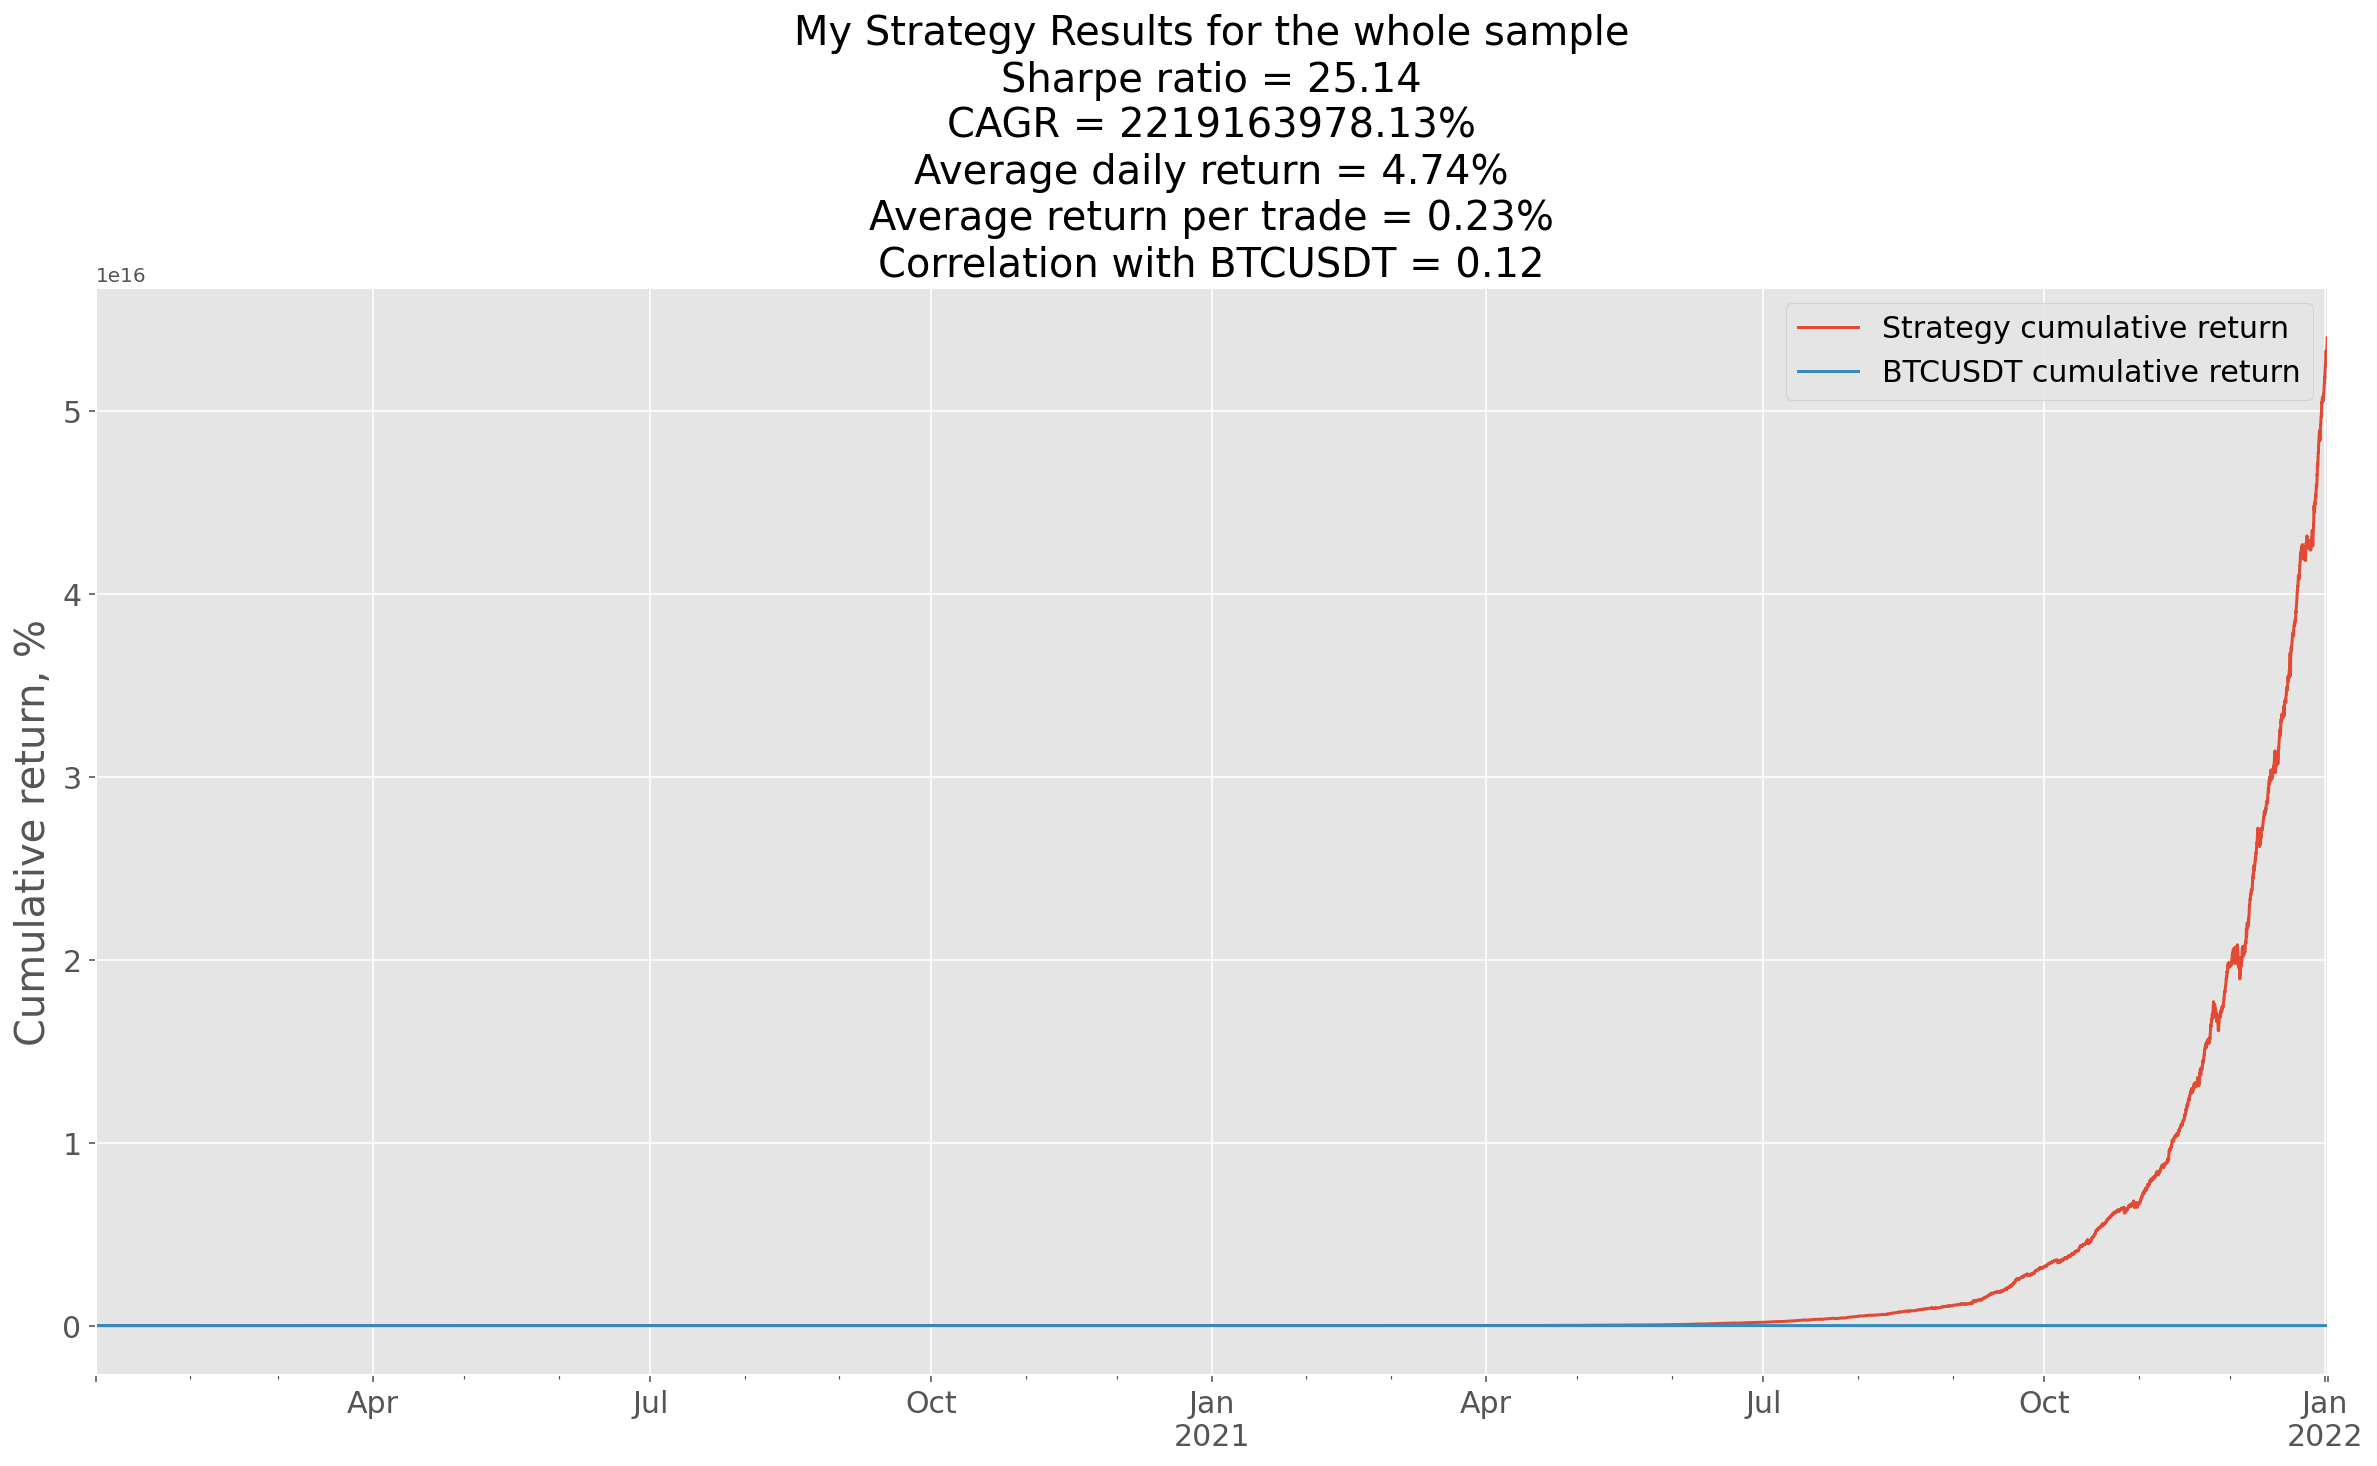

In [5]:
plot_strategy_results(final_strategy, 'My Strategy Results for the whole sample')

In [36]:
cerebro = bt.Cerebro()

# CSV files are processed to have explicit NaNs because BackTrader uses inner join logic for multiple dataframes
folder_path = 'binance_1h_processed'
for file_name in os.listdir(folder_path):
    ticker = file_name[:file_name.index('.')]
    data = bt.feeds.GenericCSVData(dataname=os.path.join(folder_path, file_name),
                                   name=ticker,
                                   nullvalue=np.nan,
                                   dtformat=('%Y-%m-%d %H:%M:%S'),
                                   timeframe=bt.TimeFrame.Minutes,
                                   compression=60,
                                   datetime=0,
                                   open=1,
                                   high=2,
                                   low=3,
                                   close=4, 
                                   volume=5,
                                   time=-1,
                                   openinterest=-1)
    cerebro.adddata(data)

cerebro.addstrategy(Strategy)
cerebro.getbroker().setcash(1000000)
cerebro.getbroker().set_coc(True)

cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')

res = cerebro.run(cheat_on_close=True, preloaded=True)
returns1h = res[0].analyzers.getbyname('timereturn').get_analysis()

2020-01-01 01:00:00 1000000.0
2020-01-01 02:00:00 996543.6130240001
2020-01-01 03:00:00 995994.8095377
2020-01-01 04:00:00 997138.442759
2020-01-01 05:00:00 995608.475929
2020-01-01 06:00:00 996524.6792169999
2020-01-01 07:00:00 998492.374757
2020-01-01 08:00:00 993947.3303170002
2020-01-01 09:00:00 993645.1267470003
2020-01-01 10:00:00 994605.8170470004
2020-01-01 11:00:00 997746.1578310002
2020-01-01 12:00:00 998324.5840560001
2020-01-01 13:00:00 998132.7593272001
2020-01-01 14:00:00 1002824.7273272004
2020-01-01 15:00:00 994823.9705472003
2020-01-01 16:00:00 995215.9437071998
2020-01-01 17:00:00 997648.1427671997
2020-01-01 18:00:00 992304.9695071995
2020-01-01 19:00:00 997458.4120371996
2020-01-01 20:00:00 998223.0115051996
2020-01-01 21:00:00 1001752.7909891995
2020-01-01 22:00:00 1006745.2285411997
2020-01-01 23:00:00 1012677.5437811998
2020-01-02 00:00:00 1014567.9651711998
2020-01-02 01:00:00 1009368.6595031997
2020-01-02 02:00:00 1010393.2628331999
2020-01-02 03:00:00 1013382.

2020-01-10 09:00:00 1404803.912552299
2020-01-10 10:00:00 1399376.8250730988
2020-01-10 11:00:00 1402081.4589077986
2020-01-10 12:00:00 1400906.9019240984
2020-01-10 13:00:00 1400013.9476952986
2020-01-10 14:00:00 1401449.6304862986
2020-01-10 15:00:00 1397066.099303499
2020-01-10 16:00:00 1404153.607093499
2020-01-10 17:00:00 1404859.7367994986
2020-01-10 18:00:00 1414806.8639114986
2020-01-10 19:00:00 1409771.5796004983
2020-01-10 20:00:00 1410769.2147504983
2020-01-10 21:00:00 1411644.3139628978
2020-01-10 22:00:00 1407789.2047428975
2020-01-10 23:00:00 1402014.0346028975
2020-01-11 00:00:00 1400976.8558268978
2020-01-11 01:00:00 1401275.1388068977
2020-01-11 02:00:00 1394110.8159568976
2020-01-11 03:00:00 1406711.3220778976
2020-01-11 04:00:00 1408424.0647978971
2020-01-11 05:00:00 1411566.9898010974
2020-01-11 06:00:00 1416728.421161098
2020-01-11 07:00:00 1412743.6845210982
2020-01-11 08:00:00 1416512.603945598
2020-01-11 09:00:00 1424673.2918855983
2020-01-11 10:00:00 1426872.73

2020-01-19 05:00:00 1713523.7701578003
2020-01-19 06:00:00 1716702.6508098005
2020-01-19 07:00:00 1718072.1391992003
2020-01-19 08:00:00 1730032.0699930005
2020-01-19 09:00:00 1729010.9518920002
2020-01-19 10:00:00 1730248.6223339997
2020-01-19 11:00:00 1722085.0323646003
2020-01-19 12:00:00 1725191.2121260008
2020-01-19 13:00:00 1738921.154834001
2020-01-19 14:00:00 1742864.151652001
2020-01-19 15:00:00 1742612.493499501
2020-01-19 16:00:00 1751047.2230015008
2020-01-19 17:00:00 1765406.4636385008
2020-01-19 18:00:00 1771827.801318501
2020-01-19 19:00:00 1775683.4788555007
2020-01-19 20:00:00 1788147.325911501
2020-01-19 21:00:00 1795973.4289335008
2020-01-19 22:00:00 1803745.236299901
2020-01-19 23:00:00 1814202.4013099005
2020-01-20 00:00:00 1818896.7495699
2020-01-20 01:00:00 1823935.4109418998
2020-01-20 02:00:00 1823870.5888419
2020-01-20 03:00:00 1826938.6473129003
2020-01-20 04:00:00 1832788.5655329004
2020-01-20 05:00:00 1835559.9764379
2020-01-20 06:00:00 1831059.9827206999
2

2020-01-28 03:00:00 2807354.229894901
2020-01-28 04:00:00 2803354.5439839014
2020-01-28 05:00:00 2805979.6969479006
2020-01-28 06:00:00 2809399.3366939006
2020-01-28 07:00:00 2811653.8451079004
2020-01-28 08:00:00 2828210.0822779005
2020-01-28 09:00:00 2828972.318477401
2020-01-28 10:00:00 2841134.232450401
2020-01-28 11:00:00 2840285.7561104014
2020-01-28 12:00:00 2831668.3426356013
2020-01-28 13:00:00 2841670.290632801
2020-01-28 14:00:00 2835595.7527848016
2020-01-28 15:00:00 2847056.970904802
2020-01-28 16:00:00 2852446.043174801
2020-01-28 17:00:00 2857243.4394848007
2020-01-28 18:00:00 2844128.4027558016
2020-01-28 19:00:00 2854859.637870802
2020-01-28 20:00:00 2851589.7633088017
2020-01-28 21:00:00 2865942.9330032016
2020-01-28 22:00:00 2869763.965422201
2020-01-28 23:00:00 2867171.0298922015
2020-01-29 00:00:00 2878772.3977622003
2020-01-29 01:00:00 2892635.4527422
2020-01-29 02:00:00 2899287.9761192007
2020-01-29 03:00:00 2915945.0189082013
2020-01-29 04:00:00 2940240.29809220

2020-02-06 10:00:00 4175599.100732311
2020-02-06 11:00:00 3930387.322832511
2020-02-06 12:00:00 3809955.7830352103
2020-02-06 13:00:00 3893199.5994352107
2020-02-06 14:00:00 3937642.16516821
2020-02-06 15:00:00 3938398.0473782094
2020-02-06 16:00:00 3937576.5249122116
2020-02-06 17:00:00 3907362.481965013
2020-02-06 18:00:00 4018627.134422712
2020-02-06 19:00:00 3955056.0966267125
2020-02-06 20:00:00 3995562.8922071117
2020-02-06 21:00:00 4050944.7248631115
2020-02-06 22:00:00 4140975.855010211
2020-02-06 23:00:00 4231023.867397211
2020-02-07 00:00:00 4215585.37907321
2020-02-07 01:00:00 4243913.957651208
2020-02-07 02:00:00 4294013.833728208
2020-02-07 03:00:00 4345179.268275809
2020-02-07 04:00:00 4390865.3331228085
2020-02-07 05:00:00 4301010.859962808
2020-02-07 06:00:00 4371974.615190307
2020-02-07 07:00:00 4369560.905940306
2020-02-07 08:00:00 4432125.804462805
2020-02-07 09:00:00 4423611.178261806
2020-02-07 10:00:00 4443347.781901807
2020-02-07 11:00:00 4436165.738275807
2020-0

2020-02-15 10:00:00 5979058.614526299
2020-02-15 11:00:00 6043525.381936299
2020-02-15 12:00:00 5996632.5124233
2020-02-15 13:00:00 6054447.031645298
2020-02-15 14:00:00 6080400.4563293
2020-02-15 15:00:00 6146678.895869301
2020-02-15 16:00:00 6048118.341913298
2020-02-15 17:00:00 6034154.175743299
2020-02-15 18:00:00 6083108.265295298
2020-02-15 19:00:00 6116669.934325298
2020-02-15 20:00:00 6158830.098161199
2020-02-15 21:00:00 6168849.663522198
2020-02-15 22:00:00 6237397.335652397
2020-02-15 23:00:00 6246843.986939397
2020-02-16 00:00:00 6292335.426882899
2020-02-16 01:00:00 6351459.719842901
2020-02-16 02:00:00 6303710.532982903
2020-02-16 03:00:00 6296573.396570202
2020-02-16 04:00:00 6283909.101925203
2020-02-16 05:00:00 6277095.060039204
2020-02-16 06:00:00 6310115.561299205
2020-02-16 07:00:00 6271472.249139205
2020-02-16 08:00:00 6326121.217619206
2020-02-16 09:00:00 6309674.200503706
2020-02-16 10:00:00 6289026.06735471
2020-02-16 11:00:00 6307385.626477307
2020-02-16 12:00:

2020-02-24 20:00:00 10436826.711139195
2020-02-24 21:00:00 10512130.450286193
2020-02-24 22:00:00 10508520.75489719
2020-02-24 23:00:00 10522667.450575886
2020-02-25 00:00:00 10512719.205205888
2020-02-25 01:00:00 10514606.907645889
2020-02-25 02:00:00 10529522.736977888
2020-02-25 03:00:00 10509494.57824588
2020-02-25 04:00:00 10611135.124163885
2020-02-25 05:00:00 10655829.631166881
2020-02-25 06:00:00 10681755.367866881
2020-02-25 07:00:00 10708169.20001888
2020-02-25 08:00:00 10789092.369638883
2020-02-25 09:00:00 10819761.793420883
2020-02-25 10:00:00 10840051.393422883
2020-02-25 11:00:00 10839543.88915979
2020-02-25 12:00:00 10891589.940414792
2020-02-25 13:00:00 10900236.726741191
2020-02-25 14:00:00 10869224.73920319
2020-02-25 15:00:00 10813267.46329519
2020-02-25 16:00:00 10778823.357995188
2020-02-25 17:00:00 10964034.417867187
2020-02-25 18:00:00 10925343.959915187
2020-02-25 19:00:00 10957841.294382187
2020-02-25 20:00:00 10955795.758676583
2020-02-25 21:00:00 11082434.46

2020-03-04 17:00:00 21301240.757112887
2020-03-04 18:00:00 21391246.07825288
2020-03-04 19:00:00 21340454.38675289
2020-03-04 20:00:00 21302276.08458417
2020-03-04 21:00:00 21320168.085744172
2020-03-04 22:00:00 21282507.82720417
2020-03-04 23:00:00 21308019.741064165
2020-03-05 00:00:00 21410788.608536173
2020-03-05 01:00:00 21396723.85072016
2020-03-05 02:00:00 21456891.256075058
2020-03-05 03:00:00 21561599.445485055
2020-03-05 04:00:00 21493459.25824825
2020-03-05 05:00:00 21659765.01937825
2020-03-05 06:00:00 21655428.805608258
2020-03-05 07:00:00 21731877.08645726
2020-03-05 08:00:00 21858485.71771726
2020-03-05 09:00:00 21788466.541441258
2020-03-05 10:00:00 21637562.850211263
2020-03-05 11:00:00 21758476.97705586
2020-03-05 12:00:00 21795386.049726855
2020-03-05 13:00:00 21785242.049450852
2020-03-05 14:00:00 22025311.428265844
2020-03-05 15:00:00 22148089.93341214
2020-03-05 16:00:00 22119510.987147138
2020-03-05 17:00:00 22239164.468994938
2020-03-05 18:00:00 22259241.6761829

2020-03-13 17:00:00 44136890.309887074
2020-03-13 18:00:00 44981386.40790707
2020-03-13 19:00:00 47550382.51342345
2020-03-13 20:00:00 48264331.13127244
2020-03-13 21:00:00 48934658.71605343
2020-03-13 22:00:00 48226288.843363434
2020-03-13 23:00:00 48365056.81598344
2020-03-14 00:00:00 48340000.81305093
2020-03-14 01:00:00 48723233.76725414
2020-03-14 02:00:00 48274105.06552415
2020-03-14 03:00:00 49653934.435193144
2020-03-14 04:00:00 50020497.95561705
2020-03-14 05:00:00 50255081.24964025
2020-03-14 06:00:00 50179873.45636623
2020-03-14 07:00:00 50335848.84195783
2020-03-14 08:00:00 50594965.740908444
2020-03-14 09:00:00 50232617.07736744
2020-03-14 10:00:00 51525523.00331244
2020-03-14 11:00:00 51962948.64866394
2020-03-14 12:00:00 52052740.74333576
2020-03-14 13:00:00 52621430.915626764
2020-03-14 14:00:00 52839850.90309976
2020-03-14 15:00:00 53201648.61701816
2020-03-14 16:00:00 53670732.25383515
2020-03-14 17:00:00 53498038.81986772
2020-03-14 18:00:00 53719636.43506872
2020-03

2020-03-22 23:00:00 137271418.02348074
2020-03-23 00:00:00 138271922.51214173
2020-03-23 01:00:00 138566944.50018075
2020-03-23 02:00:00 139560350.29165682
2020-03-23 03:00:00 140701677.02837145
2020-03-23 04:00:00 140888408.30277544
2020-03-23 05:00:00 141373595.11286545
2020-03-23 06:00:00 142666186.00525543
2020-03-23 07:00:00 144281515.49676442
2020-03-23 08:00:00 141550896.51242042
2020-03-23 09:00:00 143031593.77376541
2020-03-23 10:00:00 143726324.01283786
2020-03-23 11:00:00 144169081.6543274
2020-03-23 12:00:00 145131038.40115386
2020-03-23 13:00:00 146461246.54048786
2020-03-23 14:00:00 147134441.2378118
2020-03-23 15:00:00 148065682.0575758
2020-03-23 16:00:00 149860670.0686468
2020-03-23 17:00:00 152144070.19053477
2020-03-23 18:00:00 152474487.24234277
2020-03-23 19:00:00 152291810.37711477
2020-03-23 20:00:00 152646800.01673976
2020-03-23 21:00:00 153542206.30267683
2020-03-23 22:00:00 153691816.96494582
2020-03-23 23:00:00 155382681.4774588
2020-03-24 00:00:00 156394108.

2020-03-31 23:00:00 240915079.58532095
2020-04-01 00:00:00 243447144.48378396
2020-04-01 01:00:00 242845818.6027335
2020-04-01 02:00:00 242658617.64525348
2020-04-01 03:00:00 241712707.87725747
2020-04-01 04:00:00 241963906.6675811
2020-04-01 05:00:00 243836898.5348821
2020-04-01 06:00:00 244454394.49992007
2020-04-01 07:00:00 245584584.2151401
2020-04-01 08:00:00 244776028.34339204
2020-04-01 09:00:00 246361421.74867213
2020-04-01 10:00:00 247713331.7340199
2020-04-01 11:00:00 248543570.1636199
2020-04-01 12:00:00 248863533.138256
2020-04-01 13:00:00 250700666.14022404
2020-04-01 14:00:00 252151195.63958362
2020-04-01 15:00:00 253475350.54867965
2020-04-01 16:00:00 254472573.92991778
2020-04-01 17:00:00 253828196.0432878
2020-04-01 18:00:00 254454742.7245688
2020-04-01 19:00:00 254642820.79425448
2020-04-01 20:00:00 253727660.43562496
2020-04-01 21:00:00 255434747.72658494
2020-04-01 22:00:00 255990226.22511917
2020-04-01 23:00:00 255168288.53444818
2020-04-02 00:00:00 256143493.05400

2020-04-10 07:00:00 412086818.82134646
2020-04-10 08:00:00 413589487.7681904
2020-04-10 09:00:00 415286749.2485068
2020-04-10 10:00:00 416429768.2145598
2020-04-10 11:00:00 417161071.7083678
2020-04-10 12:00:00 418914904.2033679
2020-04-10 13:00:00 422699734.1126878
2020-04-10 14:00:00 426416497.24778116
2020-04-10 15:00:00 424350022.832573
2020-04-10 16:00:00 429932358.2934031
2020-04-10 17:00:00 429821956.39592916
2020-04-10 18:00:00 432440472.5216011
2020-04-10 19:00:00 434577105.86907184
2020-04-10 20:00:00 434899030.49816906
2020-04-10 21:00:00 436826851.25883305
2020-04-10 22:00:00 438796755.5910792
2020-04-10 23:00:00 440627129.7284652
2020-04-11 00:00:00 441757058.10080296
2020-04-11 01:00:00 443597670.4110049
2020-04-11 02:00:00 445011012.34520555
2020-04-11 03:00:00 446725482.86069566
2020-04-11 04:00:00 447739005.8636136
2020-04-11 05:00:00 451107921.61414176
2020-04-11 06:00:00 448005743.2118318
2020-04-11 07:00:00 449563639.2975043
2020-04-11 08:00:00 451143575.09521425
20

2020-04-19 13:00:00 670668810.5105773
2020-04-19 14:00:00 673321376.4867054
2020-04-19 15:00:00 673638125.4745314
2020-04-19 16:00:00 673419377.7392814
2020-04-19 17:00:00 674231719.2504584
2020-04-19 18:00:00 668004196.8700404
2020-04-19 19:00:00 668905224.6956755
2020-04-19 20:00:00 668563912.534864
2020-04-19 21:00:00 670138778.2745417
2020-04-19 22:00:00 673782446.6104699
2020-04-19 23:00:00 675513616.5306927
2020-04-20 00:00:00 683349211.4217799
2020-04-20 01:00:00 685605072.5684098
2020-04-20 02:00:00 688908205.8155166
2020-04-20 03:00:00 688206732.4750445
2020-04-20 04:00:00 691491566.6008873
2020-04-20 05:00:00 691853943.0667386
2020-04-20 06:00:00 692549882.1287408
2020-04-20 07:00:00 695487652.116341
2020-04-20 08:00:00 701159408.6500528
2020-04-20 09:00:00 701118196.9653789
2020-04-20 10:00:00 706433458.4905086
2020-04-20 11:00:00 700148569.8051226
2020-04-20 12:00:00 711782673.5198708
2020-04-20 13:00:00 713773893.3350667
2020-04-20 14:00:00 715964961.5066915
2020-04-20 15:

2020-04-28 19:00:00 1016715577.314103
2020-04-28 20:00:00 1019083648.1884744
2020-04-28 21:00:00 1019664348.0301112
2020-04-28 22:00:00 1023505575.6634951
2020-04-28 23:00:00 1025214959.9258648
2020-04-29 00:00:00 1028570516.2185214
2020-04-29 01:00:00 1027617513.8802855
2020-04-29 02:00:00 1024498781.5068319
2020-04-29 03:00:00 1027589240.2396588
2020-04-29 04:00:00 1024904738.877354
2020-04-29 05:00:00 1031739216.7947689
2020-04-29 06:00:00 1030202916.040779
2020-04-29 07:00:00 1027334390.4686178
2020-04-29 08:00:00 1026909606.5822017
2020-04-29 09:00:00 1028340148.2424386
2020-04-29 10:00:00 1027396277.9657668
2020-04-29 11:00:00 1027704931.3257182
2020-04-29 12:00:00 1031088677.2145884
2020-04-29 13:00:00 1036810316.3681324
2020-04-29 14:00:00 1042861224.7428192
2020-04-29 15:00:00 1049474275.689735
2020-04-29 16:00:00 1049246579.132716
2020-04-29 17:00:00 1044909963.7477207
2020-04-29 18:00:00 1051856698.8154569
2020-04-29 19:00:00 1062238111.1995451
2020-04-29 20:00:00 1063509900

2020-05-07 21:00:00 1652734473.210586
2020-05-07 22:00:00 1643555900.413227
2020-05-07 23:00:00 1648305444.3723822
2020-05-08 00:00:00 1664995037.582577
2020-05-08 01:00:00 1659820373.198126
2020-05-08 02:00:00 1669507758.6482158
2020-05-08 03:00:00 1660487029.510652
2020-05-08 04:00:00 1677983189.7945204
2020-05-08 05:00:00 1654806346.4183505
2020-05-08 06:00:00 1667688569.3898203
2020-05-08 07:00:00 1661001426.2810707
2020-05-08 08:00:00 1668245563.3317204
2020-05-08 09:00:00 1680647479.2352302
2020-05-08 10:00:00 1679338751.3820283
2020-05-08 11:00:00 1673121529.2606585
2020-05-08 12:00:00 1677575516.8287249
2020-05-08 13:00:00 1654553768.5955887
2020-05-08 14:00:00 1632522154.4214244
2020-05-08 15:00:00 1652343398.3989682
2020-05-08 16:00:00 1667890932.431799
2020-05-08 17:00:00 1682739230.8514493
2020-05-08 18:00:00 1685317440.188139
2020-05-08 19:00:00 1683142002.758303
2020-05-08 20:00:00 1687548959.7671554
2020-05-08 21:00:00 1697432243.717571
2020-05-08 22:00:00 1691807288.857

2020-05-17 00:00:00 2789170852.8974934
2020-05-17 01:00:00 2801379098.8138094
2020-05-17 02:00:00 2801063099.381949
2020-05-17 03:00:00 2802682508.5886683
2020-05-17 04:00:00 2795988107.822553
2020-05-17 05:00:00 2780646968.956819
2020-05-17 06:00:00 2788333606.1462407
2020-05-17 07:00:00 2783631480.769969
2020-05-17 08:00:00 2790701459.74363
2020-05-17 09:00:00 2797476255.2917995
2020-05-17 10:00:00 2809454169.2060013
2020-05-17 11:00:00 2820407488.1258454
2020-05-17 12:00:00 2839028192.9891424
2020-05-17 13:00:00 2824271702.9900455
2020-05-17 14:00:00 2835139218.6567535
2020-05-17 15:00:00 2832645843.784969
2020-05-17 16:00:00 2821162036.847504
2020-05-17 17:00:00 2835342580.214424
2020-05-17 18:00:00 2842187729.2534466
2020-05-17 19:00:00 2837078479.485132
2020-05-17 20:00:00 2851651704.8830256
2020-05-17 21:00:00 2849116070.1050267
2020-05-17 22:00:00 2855652042.32279
2020-05-17 23:00:00 2849860307.0199747
2020-05-18 00:00:00 2855110952.647221
2020-05-18 01:00:00 2869802902.011747


2020-05-26 08:00:00 3608403098.736172
2020-05-26 09:00:00 3634660885.0456676
2020-05-26 10:00:00 3646368622.5561585
2020-05-26 11:00:00 3665295047.2866488
2020-05-26 12:00:00 3683765053.1070967
2020-05-26 13:00:00 3654252620.4207172
2020-05-26 14:00:00 3685641423.178095
2020-05-26 15:00:00 3698851872.3249903
2020-05-26 16:00:00 3742902934.420014
2020-05-26 17:00:00 3755258062.9067397
2020-05-26 18:00:00 3832369533.0157757
2020-05-26 19:00:00 3845782533.126047
2020-05-26 20:00:00 3843011054.025222
2020-05-26 21:00:00 3850212814.1655345
2020-05-26 22:00:00 3808069761.3238926
2020-05-26 23:00:00 3784900067.6343446
2020-05-27 00:00:00 3809695958.973416
2020-05-27 01:00:00 3818116533.168088
2020-05-27 02:00:00 3778109600.9420695
2020-05-27 03:00:00 3803342801.8901267
2020-05-27 04:00:00 3830469671.058756
2020-05-27 05:00:00 3853997030.3671365
2020-05-27 06:00:00 3876106139.214778
2020-05-27 07:00:00 3899668935.521798
2020-05-27 08:00:00 3972993362.602624
2020-05-27 09:00:00 3969956438.58694

2020-06-04 09:00:00 5467454322.142052
2020-06-04 10:00:00 5470494983.445922
2020-06-04 11:00:00 5455173302.904918
2020-06-04 12:00:00 5433653124.1532755
2020-06-04 13:00:00 5474680452.345178
2020-06-04 14:00:00 5466179618.261093
2020-06-04 15:00:00 5437666529.490374
2020-06-04 16:00:00 5440255291.876178
2020-06-04 17:00:00 5430557347.814007
2020-06-04 18:00:00 5425700969.431965
2020-06-04 19:00:00 5424648839.75118
2020-06-04 20:00:00 5430841239.367963
2020-06-04 21:00:00 5430857912.124807
2020-06-04 22:00:00 5415917009.520144
2020-06-04 23:00:00 5441327959.674665
2020-06-05 00:00:00 5451953459.232037
2020-06-05 01:00:00 5470345137.033838
2020-06-05 02:00:00 5467234203.479351
2020-06-05 03:00:00 5456544353.244181
2020-06-05 04:00:00 5485631923.659116
2020-06-05 05:00:00 5491646025.365065
2020-06-05 06:00:00 5489156591.296004
2020-06-05 07:00:00 5465318096.927011
2020-06-05 08:00:00 5491616460.514013
2020-06-05 09:00:00 5436329298.7738695
2020-06-05 10:00:00 5472518003.087751
2020-06-05 

2020-06-13 14:00:00 7251274852.085094
2020-06-13 15:00:00 7249713075.73689
2020-06-13 16:00:00 7248130327.345767
2020-06-13 17:00:00 7266490765.524945
2020-06-13 18:00:00 7328438377.758285
2020-06-13 19:00:00 7321694599.085983
2020-06-13 20:00:00 7346250582.855124
2020-06-13 21:00:00 7322405573.22051
2020-06-13 22:00:00 7352298116.63327
2020-06-13 23:00:00 7376740680.153889
2020-06-14 00:00:00 7449331019.910972
2020-06-14 01:00:00 7429550990.304869
2020-06-14 02:00:00 7423707350.110663
2020-06-14 03:00:00 7400008062.294484
2020-06-14 04:00:00 7418458990.650809
2020-06-14 05:00:00 7423155623.965508
2020-06-14 06:00:00 7451095917.437329
2020-06-14 07:00:00 7483527527.280881
2020-06-14 08:00:00 7520547228.914873
2020-06-14 09:00:00 7534516998.155495
2020-06-14 10:00:00 7562925180.552766
2020-06-14 11:00:00 7566630473.670692
2020-06-14 12:00:00 7593208733.759856
2020-06-14 13:00:00 7527028032.166484
2020-06-14 14:00:00 7559424022.287795
2020-06-14 15:00:00 7618498596.599412
2020-06-14 16:0

2020-06-22 20:00:00 11013573255.773153
2020-06-22 21:00:00 11020726113.084251
2020-06-22 22:00:00 11034293736.313908
2020-06-22 23:00:00 11068185336.513628
2020-06-23 00:00:00 10944799680.306677
2020-06-23 01:00:00 10852722111.175297
2020-06-23 02:00:00 10903515162.76264
2020-06-23 03:00:00 10871753674.030027
2020-06-23 04:00:00 10943275370.629246
2020-06-23 05:00:00 10904054441.243227
2020-06-23 06:00:00 10952642195.07841
2020-06-23 07:00:00 10946142920.585804
2020-06-23 08:00:00 10988540554.547546
2020-06-23 09:00:00 10957281227.65929
2020-06-23 10:00:00 10894277253.619722
2020-06-23 11:00:00 10927967702.653885
2020-06-23 12:00:00 10929895014.619007
2020-06-23 13:00:00 10962508609.979073
2020-06-23 14:00:00 10976016726.00726
2020-06-23 15:00:00 11013877038.770676
2020-06-23 16:00:00 11075259379.245283
2020-06-23 17:00:00 11081109297.824217
2020-06-23 18:00:00 11075838058.401001
2020-06-23 19:00:00 11107744464.844753
2020-06-23 20:00:00 11133824152.263365
2020-06-23 21:00:00 111137022

2020-07-01 17:00:00 17039168787.029757
2020-07-01 18:00:00 17033710144.562798
2020-07-01 19:00:00 17081644965.336401
2020-07-01 20:00:00 17161703663.35293
2020-07-01 21:00:00 17303715630.626698
2020-07-01 22:00:00 17307931418.32612
2020-07-01 23:00:00 17264598906.925587
2020-07-02 00:00:00 17346732156.441235
2020-07-02 01:00:00 17347797105.160545
2020-07-02 02:00:00 17342675862.54519
2020-07-02 03:00:00 17244167731.919815
2020-07-02 04:00:00 17199190286.28189
2020-07-02 05:00:00 17136122683.729454
2020-07-02 06:00:00 17134196358.094175
2020-07-02 07:00:00 17077539876.821894
2020-07-02 08:00:00 17048231462.115253
2020-07-02 09:00:00 17086182414.37042
2020-07-02 10:00:00 17081591981.417883
2020-07-02 11:00:00 17048380295.944069
2020-07-02 12:00:00 17147355380.909702
2020-07-02 13:00:00 17178690803.37267
2020-07-02 14:00:00 17281588218.766838
2020-07-02 15:00:00 17272644074.972958
2020-07-02 16:00:00 17315795265.459366
2020-07-02 17:00:00 17447606869.93002
2020-07-02 18:00:00 17437469015.

2020-07-10 14:00:00 22249132276.16658
2020-07-10 15:00:00 22270665068.139324
2020-07-10 16:00:00 22417373297.56189
2020-07-10 17:00:00 22566821540.73825
2020-07-10 18:00:00 22369147005.068386
2020-07-10 19:00:00 22347044738.4825
2020-07-10 20:00:00 22306462575.271374
2020-07-10 21:00:00 22293271727.382477
2020-07-10 22:00:00 22326296540.17141
2020-07-10 23:00:00 22344081544.404263
2020-07-11 00:00:00 22299540533.501957
2020-07-11 01:00:00 22297800927.282425
2020-07-11 02:00:00 22241055076.37357
2020-07-11 03:00:00 22154477379.082165
2020-07-11 04:00:00 22275771913.018665
2020-07-11 05:00:00 22198770564.119083
2020-07-11 06:00:00 22225454807.540558
2020-07-11 07:00:00 22087345227.021202
2020-07-11 08:00:00 22088997129.684887
2020-07-11 09:00:00 22171161435.16563
2020-07-11 10:00:00 22246216170.978546
2020-07-11 11:00:00 22130239709.39353
2020-07-11 12:00:00 22176098943.46379
2020-07-11 13:00:00 22262873653.99304
2020-07-11 14:00:00 22349984666.714
2020-07-11 15:00:00 22434349112.473995


2020-07-19 11:00:00 30189542615.8361
2020-07-19 12:00:00 30257399409.815186
2020-07-19 13:00:00 30052360021.145416
2020-07-19 14:00:00 30097873787.886574
2020-07-19 15:00:00 30267453857.365314
2020-07-19 16:00:00 30513539798.15176
2020-07-19 17:00:00 30669052317.412064
2020-07-19 18:00:00 30771310755.038036
2020-07-19 19:00:00 30716878297.01226
2020-07-19 20:00:00 30688341742.437992
2020-07-19 21:00:00 30724815562.337246
2020-07-19 22:00:00 30995031947.15076
2020-07-19 23:00:00 30571728552.84218
2020-07-20 00:00:00 30561772713.207413
2020-07-20 01:00:00 30339246983.339737
2020-07-20 02:00:00 30574706291.65267
2020-07-20 03:00:00 30719883895.079754
2020-07-20 04:00:00 30939326407.845154
2020-07-20 05:00:00 31028821175.94654
2020-07-20 06:00:00 31123951335.369564
2020-07-20 07:00:00 30936570527.411724
2020-07-20 08:00:00 30899182921.765427
2020-07-20 09:00:00 30987940774.450813
2020-07-20 10:00:00 31254775624.62734
2020-07-20 11:00:00 31379719083.412495
2020-07-20 12:00:00 31101963933.79

2020-07-28 11:00:00 61599737306.74146
2020-07-28 12:00:00 61762581412.439804
2020-07-28 13:00:00 62304801764.92627
2020-07-28 14:00:00 62767932527.129524
2020-07-28 15:00:00 62849361713.96437
2020-07-28 16:00:00 63362438062.25497
2020-07-28 17:00:00 63351696839.74085
2020-07-28 18:00:00 63381668661.804665
2020-07-28 19:00:00 63822750267.78774
2020-07-28 20:00:00 64091696517.019485
2020-07-28 21:00:00 64270887139.40703
2020-07-28 22:00:00 64413772792.7138
2020-07-28 23:00:00 64644662431.25585
2020-07-29 00:00:00 64225196685.66182
2020-07-29 01:00:00 64832469488.35259
2020-07-29 02:00:00 64738354394.701584
2020-07-29 03:00:00 64896330162.677605
2020-07-29 04:00:00 65046350149.08789
2020-07-29 05:00:00 64938638626.67645
2020-07-29 06:00:00 64918038840.19199
2020-07-29 07:00:00 65204750988.06058
2020-07-29 08:00:00 65360546048.28161
2020-07-29 09:00:00 64871002538.55987
2020-07-29 10:00:00 64872064558.8568
2020-07-29 11:00:00 64572624581.94456
2020-07-29 12:00:00 64358954247.96736
2020-07-

2020-08-06 16:00:00 87645400703.12445
2020-08-06 17:00:00 88397269994.77127
2020-08-06 18:00:00 89055352062.93204
2020-08-06 19:00:00 88922451955.37799
2020-08-06 20:00:00 89494001874.34778
2020-08-06 21:00:00 89955568284.87314
2020-08-06 22:00:00 90191011327.63298
2020-08-06 23:00:00 90234339499.80058
2020-08-07 00:00:00 90590183354.21532
2020-08-07 01:00:00 90573953637.69069
2020-08-07 02:00:00 90806019204.44258
2020-08-07 03:00:00 91842520966.74265
2020-08-07 04:00:00 91043581491.48055
2020-08-07 05:00:00 91323460573.86346
2020-08-07 06:00:00 91658966674.38855
2020-08-07 07:00:00 91966535437.23819
2020-08-07 08:00:00 92546046543.7121
2020-08-07 09:00:00 92876554368.29793
2020-08-07 10:00:00 92649999238.62404
2020-08-07 11:00:00 93104765836.762
2020-08-07 12:00:00 93961812041.84978
2020-08-07 13:00:00 94551615785.18826
2020-08-07 14:00:00 95300270604.96817
2020-08-07 15:00:00 95714975845.37776
2020-08-07 16:00:00 95736372946.8271
2020-08-07 17:00:00 95570504382.76799
2020-08-07 18:00

2020-08-15 23:00:00 110940887562.05875
2020-08-16 00:00:00 111213479812.91078
2020-08-16 01:00:00 112598078876.41438
2020-08-16 02:00:00 113784857918.40314
2020-08-16 03:00:00 113009195165.21858
2020-08-16 04:00:00 113607023065.70323
2020-08-16 05:00:00 113944316136.57277
2020-08-16 06:00:00 114455632524.08252
2020-08-16 07:00:00 114605530961.79327
2020-08-16 08:00:00 115268482632.04051
2020-08-16 09:00:00 114877090680.61903
2020-08-16 10:00:00 113948279367.04266
2020-08-16 11:00:00 114496961610.78867
2020-08-16 12:00:00 116097002325.26962
2020-08-16 13:00:00 117207634316.73837
2020-08-16 14:00:00 116713586685.8651
2020-08-16 15:00:00 115236048120.79053
2020-08-16 16:00:00 115671261542.94812
2020-08-16 17:00:00 115622975686.10541
2020-08-16 18:00:00 115821297486.05725
2020-08-16 19:00:00 116281690605.55263
2020-08-16 20:00:00 116213224723.64342
2020-08-16 21:00:00 116736222135.63853
2020-08-16 22:00:00 117895782036.75537
2020-08-16 23:00:00 118479761821.53522
2020-08-17 00:00:00 118036

2020-08-24 20:00:00 193660144597.37735
2020-08-24 21:00:00 195286684717.7778
2020-08-24 22:00:00 194893749184.29
2020-08-24 23:00:00 194526250446.76666
2020-08-25 00:00:00 195546100231.23434
2020-08-25 01:00:00 195576750557.78046
2020-08-25 02:00:00 196259809082.27332
2020-08-25 03:00:00 196015288511.16296
2020-08-25 04:00:00 196688109082.25464
2020-08-25 05:00:00 197152512240.84
2020-08-25 06:00:00 197817041828.73297
2020-08-25 07:00:00 198338182380.34854
2020-08-25 08:00:00 199570055265.91443
2020-08-25 09:00:00 200030020932.20435
2020-08-25 10:00:00 199314268150.7163
2020-08-25 11:00:00 199119670478.49036
2020-08-25 12:00:00 200156929055.48236
2020-08-25 13:00:00 198715369970.5585
2020-08-25 14:00:00 199399430690.8106
2020-08-25 15:00:00 197995253642.69208
2020-08-25 16:00:00 197973156928.30118
2020-08-25 17:00:00 199974087770.92297
2020-08-25 18:00:00 200764454987.876
2020-08-25 19:00:00 201626695100.40262
2020-08-25 20:00:00 202180673243.80545
2020-08-25 21:00:00 203603581565.1591

2020-09-02 18:00:00 259512642775.17188
2020-09-02 19:00:00 261358606074.42584
2020-09-02 20:00:00 260889109456.17606
2020-09-02 21:00:00 262612136972.82297
2020-09-02 22:00:00 264659588434.68082
2020-09-02 23:00:00 264089510497.5708
2020-09-03 00:00:00 264322342225.51242
2020-09-03 01:00:00 261831225156.01392
2020-09-03 02:00:00 259929427228.71722
2020-09-03 03:00:00 258792936008.88602
2020-09-03 04:00:00 259569983758.45255
2020-09-03 05:00:00 258423522729.6727
2020-09-03 06:00:00 260049233629.6283
2020-09-03 07:00:00 260394803322.47583
2020-09-03 08:00:00 261856251256.56607
2020-09-03 09:00:00 262610775650.48468
2020-09-03 10:00:00 262320970940.8503
2020-09-03 11:00:00 256498981901.04077
2020-09-03 12:00:00 260033429240.34686
2020-09-03 13:00:00 262973605265.99496
2020-09-03 14:00:00 264834244220.84775
2020-09-03 15:00:00 267423360994.0212
2020-09-03 16:00:00 263899202034.3827
2020-09-03 17:00:00 267820406797.9445
2020-09-03 18:00:00 271702055730.42816
2020-09-03 19:00:00 274907157405

2020-09-11 20:00:00 421935898626.8783
2020-09-11 21:00:00 424099093524.29675
2020-09-11 22:00:00 427050844730.1358
2020-09-11 23:00:00 427128064697.4383
2020-09-12 00:00:00 425557683979.7334
2020-09-12 01:00:00 426420301114.96924
2020-09-12 02:00:00 427370356893.5991
2020-09-12 03:00:00 428109152147.3468
2020-09-12 04:00:00 427654117670.10657
2020-09-12 05:00:00 428865068741.12964
2020-09-12 06:00:00 428124318676.629
2020-09-12 07:00:00 427512815918.7766
2020-09-12 08:00:00 425218046968.3572
2020-09-12 09:00:00 425889244181.10913
2020-09-12 10:00:00 425765721616.2778
2020-09-12 11:00:00 428056761124.9093
2020-09-12 12:00:00 432120458466.3155
2020-09-12 13:00:00 432995539860.3269
2020-09-12 14:00:00 434387347875.573
2020-09-12 15:00:00 429778114413.58356
2020-09-12 16:00:00 428558411647.7751
2020-09-12 17:00:00 427857523848.6692
2020-09-12 18:00:00 426977338019.08765
2020-09-12 19:00:00 431480655988.52386
2020-09-12 20:00:00 433347461616.2044
2020-09-12 21:00:00 430572428779.8166
2020-0

2020-09-20 22:00:00 617533015360.3859
2020-09-20 23:00:00 618115989293.7853
2020-09-21 00:00:00 614045391709.2356
2020-09-21 01:00:00 615621521719.1935
2020-09-21 02:00:00 610354845121.1803
2020-09-21 03:00:00 609675265502.5681
2020-09-21 04:00:00 611295800550.3865
2020-09-21 05:00:00 615746093927.4061
2020-09-21 06:00:00 612519322755.605
2020-09-21 07:00:00 613024774030.6475
2020-09-21 08:00:00 607090946165.2294
2020-09-21 09:00:00 592512470449.4833
2020-09-21 10:00:00 603686481882.4216
2020-09-21 11:00:00 607313847527.7195
2020-09-21 12:00:00 614360482670.7042
2020-09-21 13:00:00 626936428333.9878
2020-09-21 14:00:00 633599822757.0244
2020-09-21 15:00:00 641053808247.5933
2020-09-21 16:00:00 647387306620.6385
2020-09-21 17:00:00 649281385536.4292
2020-09-21 18:00:00 648826320949.2534
2020-09-21 19:00:00 650697934501.2457
2020-09-21 20:00:00 650591992345.4646
2020-09-21 21:00:00 655255095278.8348
2020-09-21 22:00:00 656635934317.1537
2020-09-21 23:00:00 653535192645.9895
2020-09-22 00

2020-09-30 02:00:00 880702209068.896
2020-09-30 03:00:00 880572366975.7
2020-09-30 04:00:00 879135181644.4299
2020-09-30 05:00:00 883775007689.1515
2020-09-30 06:00:00 887497001515.3103
2020-09-30 07:00:00 887101596808.0409
2020-09-30 08:00:00 886206188872.1377
2020-09-30 09:00:00 885198583750.7648
2020-09-30 10:00:00 883751892418.635
2020-09-30 11:00:00 881062879711.5975
2020-09-30 12:00:00 888644967601.7941
2020-09-30 13:00:00 886569380901.577
2020-09-30 14:00:00 888777817559.0735
2020-09-30 15:00:00 886727391399.921
2020-09-30 16:00:00 882450684136.1716
2020-09-30 17:00:00 883539471098.067
2020-09-30 18:00:00 882607629371.8994
2020-09-30 19:00:00 886943783702.8175
2020-09-30 20:00:00 891741456134.3756
2020-09-30 21:00:00 892436769841.9778
2020-09-30 22:00:00 894957210586.3732
2020-09-30 23:00:00 896297679351.6006
2020-10-01 00:00:00 898228103284.2559
2020-10-01 01:00:00 895968385214.7524
2020-10-01 02:00:00 893596388677.667
2020-10-01 03:00:00 890132857147.2927
2020-10-01 04:00:00 8

2020-10-09 01:00:00 1135395246204.3562
2020-10-09 02:00:00 1141656413202.1057
2020-10-09 03:00:00 1140970793426.1882
2020-10-09 04:00:00 1138654619617.1855
2020-10-09 05:00:00 1137279642218.428
2020-10-09 06:00:00 1150228831149.249
2020-10-09 07:00:00 1147120945201.0488
2020-10-09 08:00:00 1147739870996.2664
2020-10-09 09:00:00 1145009616521.7258
2020-10-09 10:00:00 1149933789449.4724
2020-10-09 11:00:00 1146700562178.012
2020-10-09 12:00:00 1156843360522.0137
2020-10-09 13:00:00 1160580766326.4421
2020-10-09 14:00:00 1153601167527.2246
2020-10-09 15:00:00 1156962164359.9277
2020-10-09 16:00:00 1173519717613.0164
2020-10-09 17:00:00 1163185549091.0764
2020-10-09 18:00:00 1171457878645.689
2020-10-09 19:00:00 1172373364850.5266
2020-10-09 20:00:00 1177943368744.1604
2020-10-09 21:00:00 1175435826891.4546
2020-10-09 22:00:00 1178812852736.4712
2020-10-09 23:00:00 1180402012905.8962
2020-10-10 00:00:00 1183866163671.0862
2020-10-10 01:00:00 1186865575404.6157
2020-10-10 02:00:00 119293905

2020-10-17 21:00:00 1685018612042.4243
2020-10-17 22:00:00 1684588274762.8745
2020-10-17 23:00:00 1685119547635.5984
2020-10-18 00:00:00 1682744227067.6045
2020-10-18 01:00:00 1687680457031.381
2020-10-18 02:00:00 1683324777620.5134
2020-10-18 03:00:00 1685082382196.378
2020-10-18 04:00:00 1689216884635.4644
2020-10-18 05:00:00 1690733325746.8545
2020-10-18 06:00:00 1686854056493.3113
2020-10-18 07:00:00 1682149286199.1394
2020-10-18 08:00:00 1682965633709.2883
2020-10-18 09:00:00 1679261804522.326
2020-10-18 10:00:00 1679282007779.454
2020-10-18 11:00:00 1680843525856.1963
2020-10-18 12:00:00 1700408314214.6062
2020-10-18 13:00:00 1690505516772.0457
2020-10-18 14:00:00 1686866614003.1682
2020-10-18 15:00:00 1683904216437.9653
2020-10-18 16:00:00 1684128916528.307
2020-10-18 17:00:00 1680674646147.7944
2020-10-18 18:00:00 1680014441027.1611
2020-10-18 19:00:00 1685892655493.6797
2020-10-18 20:00:00 1691252972534.3442
2020-10-18 21:00:00 1690825217623.108
2020-10-18 22:00:00 16924590223

2020-10-26 17:00:00 2000305630276.8494
2020-10-26 18:00:00 2001536166093.1663
2020-10-26 19:00:00 2000215432933.099
2020-10-26 20:00:00 2009032928761.5615
2020-10-26 21:00:00 2010163574549.2078
2020-10-26 22:00:00 2026524112416.179
2020-10-26 23:00:00 2034817909821.117
2020-10-27 00:00:00 2048033052663.4998
2020-10-27 01:00:00 2031512134684.3853
2020-10-27 02:00:00 2042070836236.0164
2020-10-27 03:00:00 2043231036505.545
2020-10-27 04:00:00 2045825126214.7449
2020-10-27 05:00:00 2057024689399.448
2020-10-27 06:00:00 2053820570014.4722
2020-10-27 07:00:00 2055964063728.4849
2020-10-27 08:00:00 2048601937277.915
2020-10-27 09:00:00 2053877517413.1116
2020-10-27 10:00:00 2066317167444.7178
2020-10-27 11:00:00 2075870388648.8633
2020-10-27 12:00:00 2087083701311.243
2020-10-27 13:00:00 2073404468156.291
2020-10-27 14:00:00 2082363262953.3037
2020-10-27 15:00:00 2078604064565.2825
2020-10-27 16:00:00 2099569934861.2322
2020-10-27 17:00:00 2099379802802.5264
2020-10-27 18:00:00 2092091701897

2020-11-04 17:00:00 2998548006685.8354
2020-11-04 18:00:00 3014309949062.167
2020-11-04 19:00:00 3002446707722.061
2020-11-04 20:00:00 3012244031114.3203
2020-11-04 21:00:00 3009592949126.5957
2020-11-04 22:00:00 3003547551870.21
2020-11-04 23:00:00 3016866677228.5674
2020-11-05 00:00:00 3014130437927.7915
2020-11-05 01:00:00 3034140049072.817
2020-11-05 02:00:00 3010325051160.587
2020-11-05 03:00:00 3026345519063.826
2020-11-05 04:00:00 3012096515018.8516
2020-11-05 05:00:00 3040802384629.5938
2020-11-05 06:00:00 3046472011057.2666
2020-11-05 07:00:00 3058215384010.196
2020-11-05 08:00:00 3064537936853.7896
2020-11-05 09:00:00 3067332994333.1313
2020-11-05 10:00:00 3082809174675.863
2020-11-05 11:00:00 3105171125921.5635
2020-11-05 12:00:00 3093837790986.501
2020-11-05 13:00:00 3126269935101.5435
2020-11-05 14:00:00 3072444519330.732
2020-11-05 15:00:00 3090407029412.6704
2020-11-05 16:00:00 3129443119786.798
2020-11-05 17:00:00 3140522431518.0547
2020-11-05 18:00:00 3152790753424.914

2020-11-13 20:00:00 5414921198789.7705
2020-11-13 21:00:00 5419576477296.093
2020-11-13 22:00:00 5390180472702.378
2020-11-13 23:00:00 5409834075117.763
2020-11-14 00:00:00 5459316715947.646
2020-11-14 01:00:00 5495286213640.306
2020-11-14 02:00:00 5517449660734.033
2020-11-14 03:00:00 5524757265064.474
2020-11-14 04:00:00 5516619358908.02
2020-11-14 05:00:00 5539307233390.537
2020-11-14 06:00:00 5489540394220.727
2020-11-14 07:00:00 5508656154136.062
2020-11-14 08:00:00 5503694108862.699
2020-11-14 09:00:00 5464645229534.169
2020-11-14 10:00:00 5497114647463.1045
2020-11-14 11:00:00 5443012569148.18
2020-11-14 12:00:00 5394160811157.137
2020-11-14 13:00:00 5414352974375.108
2020-11-14 14:00:00 5459368758187.146
2020-11-14 15:00:00 5480539929384.67
2020-11-14 16:00:00 5513815719363.268
2020-11-14 17:00:00 5513343671633.061
2020-11-14 18:00:00 5473150358453.248
2020-11-14 19:00:00 5431224348705.794
2020-11-14 20:00:00 5462818368943.14
2020-11-14 21:00:00 5490602996507.837
2020-11-14 22:

2020-11-23 00:00:00 9018976273309.387
2020-11-23 01:00:00 9047469946728.277
2020-11-23 02:00:00 9068628356301.057
2020-11-23 03:00:00 9087143929180.871
2020-11-23 04:00:00 9115098322035.484
2020-11-23 05:00:00 9103725371255.133
2020-11-23 06:00:00 9091170894688.049
2020-11-23 07:00:00 9117400325867.236
2020-11-23 08:00:00 9119125222749.436
2020-11-23 09:00:00 9192151319808.812
2020-11-23 10:00:00 9171853903972.486
2020-11-23 11:00:00 9267591199010.557
2020-11-23 12:00:00 9221023231578.686
2020-11-23 13:00:00 9221768951639.98
2020-11-23 14:00:00 9183473865420.062
2020-11-23 15:00:00 9242324466370.342
2020-11-23 16:00:00 9232254048992.002
2020-11-23 17:00:00 9254113849207.373
2020-11-23 18:00:00 9313980557495.184
2020-11-23 19:00:00 9390753862851.246
2020-11-23 20:00:00 9349795433538.283
2020-11-23 21:00:00 9420790612273.197
2020-11-23 22:00:00 9399714590588.227
2020-11-23 23:00:00 9396767169776.066
2020-11-24 00:00:00 9383895634615.908
2020-11-24 01:00:00 9326067131109.85
2020-11-24 02:

2020-12-01 22:00:00 17383545550975.79
2020-12-01 23:00:00 17355354557585.607
2020-12-02 00:00:00 17527495388296.055
2020-12-02 01:00:00 17520333301970.78
2020-12-02 02:00:00 17503309268656.36
2020-12-02 03:00:00 17614204687137.945
2020-12-02 04:00:00 17669225755357.85
2020-12-02 05:00:00 17685733724722.543
2020-12-02 06:00:00 17770227824569.355
2020-12-02 07:00:00 17651911877424.684
2020-12-02 08:00:00 17755532096181.55
2020-12-02 09:00:00 17766248149717.168
2020-12-02 10:00:00 17764003908402.516
2020-12-02 11:00:00 17851484365341.56
2020-12-02 12:00:00 17913362117335.957
2020-12-02 13:00:00 17803550460527.164
2020-12-02 14:00:00 17822738430511.88
2020-12-02 15:00:00 17714124080160.402
2020-12-02 16:00:00 17793581755107.387
2020-12-02 17:00:00 17893063954627.88
2020-12-02 18:00:00 18162946619153.6
2020-12-02 19:00:00 18187910391918.13
2020-12-02 20:00:00 18372472133362.24
2020-12-02 21:00:00 18389530318235.8
2020-12-02 22:00:00 18571434423132.438
2020-12-02 23:00:00 18578998674918.305


2020-12-11 01:00:00 25765464300273.332
2020-12-11 02:00:00 25755690743094.016
2020-12-11 03:00:00 25815135838690.117
2020-12-11 04:00:00 25889977032609.758
2020-12-11 05:00:00 25850884613893.08
2020-12-11 06:00:00 25958423397462.508
2020-12-11 07:00:00 26014107648931.215
2020-12-11 08:00:00 26082582288525.57
2020-12-11 09:00:00 26210289958373.33
2020-12-11 10:00:00 26249837526489.31
2020-12-11 11:00:00 26278402378238.81
2020-12-11 12:00:00 26618058644074.715
2020-12-11 13:00:00 26708142843652.832
2020-12-11 14:00:00 26728976121525.812
2020-12-11 15:00:00 26664559172824.617
2020-12-11 16:00:00 26772556795902.414
2020-12-11 17:00:00 26816367815353.527
2020-12-11 18:00:00 26962672757381.387
2020-12-11 19:00:00 27022418816016.516
2020-12-11 20:00:00 27010316605113.484
2020-12-11 21:00:00 27056497123872.91
2020-12-11 22:00:00 26933202262826.5
2020-12-11 23:00:00 27122015864239.883
2020-12-12 00:00:00 27632408479881.008
2020-12-12 01:00:00 27804144000228.875
2020-12-12 02:00:00 2792840849339

2020-12-20 03:00:00 44290038728822.195
2020-12-20 04:00:00 44208664311813.74
2020-12-20 05:00:00 44433861201654.484
2020-12-20 06:00:00 44680264269047.54
2020-12-20 07:00:00 44630288600655.234
2020-12-20 08:00:00 44451444933959.85
2020-12-20 09:00:00 44508473972391.65
2020-12-20 10:00:00 45187830538843.164
2020-12-20 11:00:00 45573372921714.93
2020-12-20 12:00:00 40853730248681.664
2020-12-20 13:00:00 41536581161775.43
2020-12-20 14:00:00 41310110245462.055
2020-12-20 15:00:00 41403309104062.26
2020-12-20 16:00:00 41287519847903.89
2020-12-20 17:00:00 41300316368083.55
2020-12-20 18:00:00 41839846090951.44
2020-12-20 19:00:00 42011988423560.15
2020-12-20 20:00:00 42149126566597.31
2020-12-20 21:00:00 41905332655772.65
2020-12-20 22:00:00 42374762215277.96
2020-12-20 23:00:00 42518204054560.15
2020-12-21 00:00:00 42944568799123.0
2020-12-21 01:00:00 42713222537726.445
2020-12-21 02:00:00 42818970886369.58
2020-12-21 03:00:00 42176846319794.125
2020-12-21 04:00:00 42964344180120.9
2020-1

2020-12-29 03:00:00 72385892020210.55
2020-12-29 04:00:00 73169282759648.5
2020-12-29 05:00:00 73081929013123.23
2020-12-29 06:00:00 73299608136948.84
2020-12-29 07:00:00 73040739410695.17
2020-12-29 08:00:00 73466293952461.08
2020-12-29 09:00:00 74083250563607.22
2020-12-29 10:00:00 72958558057176.44
2020-12-29 11:00:00 73888356627606.38
2020-12-29 12:00:00 73784777677067.28
2020-12-29 13:00:00 73830628519856.56
2020-12-29 14:00:00 74322705167642.2
2020-12-29 15:00:00 73809423942061.67
2020-12-29 16:00:00 74495989437677.73
2020-12-29 17:00:00 73755245463965.97
2020-12-29 18:00:00 74295841464512.88
2020-12-29 19:00:00 74783186285980.77
2020-12-29 20:00:00 74847272892749.95
2020-12-29 21:00:00 75537196063056.75
2020-12-29 22:00:00 75667690442115.03
2020-12-29 23:00:00 75989233832441.52
2020-12-30 00:00:00 75990956389093.52
2020-12-30 01:00:00 76468978173070.05
2020-12-30 02:00:00 76547800658899.88
2020-12-30 03:00:00 76375273505059.19
2020-12-30 04:00:00 76134410396781.39
2020-12-30 05:

2021-01-07 06:00:00 135336748014594.53
2021-01-07 07:00:00 135802896713556.17
2021-01-07 08:00:00 135236486725751.66
2021-01-07 09:00:00 138056778328922.81
2021-01-07 10:00:00 137817106816665.77
2021-01-07 11:00:00 137721946392961.03
2021-01-07 12:00:00 138599104585952.94
2021-01-07 13:00:00 137666406442683.22
2021-01-07 14:00:00 138481330104457.2
2021-01-07 15:00:00 137743983760455.84
2021-01-07 16:00:00 140352214939026.19
2021-01-07 17:00:00 140340163242540.5
2021-01-07 18:00:00 140583749552342.33
2021-01-07 19:00:00 143893608653388.88
2021-01-07 20:00:00 145071275268707.34
2021-01-07 21:00:00 145784680697457.0
2021-01-07 22:00:00 146628327857377.06
2021-01-07 23:00:00 147926888842279.94
2021-01-08 00:00:00 147477462677496.75
2021-01-08 01:00:00 150795936680077.3
2021-01-08 02:00:00 150987859279607.12
2021-01-08 03:00:00 156649445736283.25
2021-01-08 04:00:00 155533567086890.75
2021-01-08 05:00:00 157593395643017.22
2021-01-08 06:00:00 157960904456037.25
2021-01-08 07:00:00 156448307

2021-01-16 04:00:00 297495272374899.94
2021-01-16 05:00:00 296150077922754.7
2021-01-16 06:00:00 291849930081850.3
2021-01-16 07:00:00 294810280458020.0
2021-01-16 08:00:00 293017267782353.7
2021-01-16 09:00:00 293676078702607.75
2021-01-16 10:00:00 293140880046994.0
2021-01-16 11:00:00 294376409733782.4
2021-01-16 12:00:00 293414849953160.5
2021-01-16 13:00:00 293822883778725.44
2021-01-16 14:00:00 292622963682842.3
2021-01-16 15:00:00 291679466415154.0
2021-01-16 16:00:00 294393441118135.94
2021-01-16 17:00:00 295702495025442.6
2021-01-16 18:00:00 294319495772146.56
2021-01-16 19:00:00 297689926820000.5
2021-01-16 20:00:00 296744253475889.25
2021-01-16 21:00:00 299640179862266.9
2021-01-16 22:00:00 299453710258534.94
2021-01-16 23:00:00 302104716934906.25
2021-01-17 00:00:00 303683106047187.06
2021-01-17 01:00:00 301203473913526.9
2021-01-17 02:00:00 305160877110588.6
2021-01-17 03:00:00 306387417163742.25
2021-01-17 04:00:00 307363844153484.0
2021-01-17 05:00:00 307966977587738.25
2

2021-01-25 06:00:00 499453829360787.1
2021-01-25 07:00:00 500289504945281.6
2021-01-25 08:00:00 500028739769994.8
2021-01-25 09:00:00 503347004121829.5
2021-01-25 10:00:00 508446489781811.44
2021-01-25 11:00:00 505615414782463.1
2021-01-25 12:00:00 511263508233702.0
2021-01-25 13:00:00 512787996971278.1
2021-01-25 14:00:00 514656163054990.9
2021-01-25 15:00:00 516961394745018.1
2021-01-25 16:00:00 518639363629350.44
2021-01-25 17:00:00 520612611535226.5
2021-01-25 18:00:00 522375687091489.56
2021-01-25 19:00:00 525512076880654.94
2021-01-25 20:00:00 532358264989541.2
2021-01-25 21:00:00 536873050677911.1
2021-01-25 22:00:00 538354103974035.1
2021-01-25 23:00:00 538832747637374.56
2021-01-26 00:00:00 548993870234029.06
2021-01-26 01:00:00 547910633206980.1
2021-01-26 02:00:00 552678328663035.94
2021-01-26 03:00:00 549870794824693.3
2021-01-26 04:00:00 559096316174957.4
2021-01-26 05:00:00 560402049220255.4
2021-01-26 06:00:00 561068894120535.0
2021-01-26 07:00:00 564934323313107.0
2021-

2021-02-03 06:00:00 1024483985308471.8
2021-02-03 07:00:00 1035538284641582.5
2021-02-03 08:00:00 1037313988478936.1
2021-02-03 09:00:00 1029123901865543.5
2021-02-03 10:00:00 1037777392959772.5
2021-02-03 11:00:00 1050975400047882.2
2021-02-03 12:00:00 1045018449092668.0
2021-02-03 13:00:00 1045444546137304.5
2021-02-03 14:00:00 1035615068230486.2
2021-02-03 15:00:00 1037457549081824.4
2021-02-03 16:00:00 1041721877265875.5
2021-02-03 17:00:00 1042417018216574.4
2021-02-03 18:00:00 1042566212197395.8
2021-02-03 19:00:00 1051630190807433.8
2021-02-03 20:00:00 1054881793307764.9
2021-02-03 21:00:00 1057767005410157.2
2021-02-03 22:00:00 1037358458840423.0
2021-02-03 23:00:00 1048754872897813.6
2021-02-04 00:00:00 1040584787922825.6
2021-02-04 01:00:00 1050201454276536.8
2021-02-04 02:00:00 1049599204206748.8
2021-02-04 03:00:00 1045518721738024.2
2021-02-04 04:00:00 1046970391306797.1
2021-02-04 05:00:00 1059559280408586.2
2021-02-04 06:00:00 1053068452019617.5
2021-02-04 07:00:00 10542

2021-02-12 05:00:00 1569974141992037.8
2021-02-12 06:00:00 1560394512189990.8
2021-02-12 07:00:00 1552875614444397.8
2021-02-12 08:00:00 1516544129310793.0
2021-02-12 09:00:00 1529716690137910.2
2021-02-12 10:00:00 1553029229569153.0
2021-02-12 11:00:00 1554212244414880.2
2021-02-12 12:00:00 1557133836095012.5
2021-02-12 13:00:00 1565802585598341.5
2021-02-12 14:00:00 1585505784221318.0
2021-02-12 15:00:00 1604646186838280.0
2021-02-12 16:00:00 1599308705540112.5
2021-02-12 17:00:00 1572795745144382.2
2021-02-12 18:00:00 1607412356377274.5
2021-02-12 19:00:00 1620603167647222.2
2021-02-12 20:00:00 1630045189468341.8
2021-02-12 21:00:00 1641922390428045.2
2021-02-12 22:00:00 1644033099880041.2
2021-02-12 23:00:00 1626760223570006.8
2021-02-13 00:00:00 1633868977626825.8
2021-02-13 01:00:00 1642050990893788.2
2021-02-13 02:00:00 1614513421387460.8
2021-02-13 03:00:00 1608237333518664.8
2021-02-13 04:00:00 1593518968910465.0
2021-02-13 05:00:00 1610287706085284.0
2021-02-13 06:00:00 16092

2021-02-21 03:00:00 2557949948020983.0
2021-02-21 04:00:00 2564489665449518.5
2021-02-21 05:00:00 2566156066713074.5
2021-02-21 06:00:00 2562688081113997.5
2021-02-21 07:00:00 2533586364547053.0
2021-02-21 08:00:00 2534380156128293.5
2021-02-21 09:00:00 2494257574444349.0
2021-02-21 10:00:00 2536827942150519.5
2021-02-21 11:00:00 2557513035437307.0
2021-02-21 12:00:00 2547362328624034.0
2021-02-21 13:00:00 2565307612702083.0
2021-02-21 14:00:00 2560248512678553.0
2021-02-21 15:00:00 2541467837390816.5
2021-02-21 16:00:00 2543069804730150.5
2021-02-21 17:00:00 2560854950731920.5
2021-02-21 18:00:00 2569797294519211.0
2021-02-21 19:00:00 2549065756506835.0
2021-02-21 20:00:00 2557813540704716.0
2021-02-21 21:00:00 2575189513447729.0
2021-02-21 22:00:00 2603082497427999.0
2021-02-21 23:00:00 2603032334976322.5
2021-02-22 00:00:00 2614388589503629.5
2021-02-22 01:00:00 2612274019123873.5
2021-02-22 02:00:00 2610740095887429.5
2021-02-22 03:00:00 2616141381870243.0
2021-02-22 04:00:00 26003

2021-03-01 23:00:00 4483610665934686.0
2021-03-02 00:00:00 4496162057395160.5
2021-03-02 01:00:00 4511574435142723.0
2021-03-02 02:00:00 4539530928628879.0
2021-03-02 03:00:00 4515571662622605.0
2021-03-02 04:00:00 4525934732404706.0
2021-03-02 05:00:00 4476139623986519.5
2021-03-02 06:00:00 4459169242152918.0
2021-03-02 07:00:00 4485651101059482.0
2021-03-02 08:00:00 4518987192624371.0
2021-03-02 09:00:00 4548073003632760.0
2021-03-02 10:00:00 4554426096352807.0
2021-03-02 11:00:00 4554205298357916.0
2021-03-02 12:00:00 4550602116404096.0
2021-03-02 13:00:00 4600658125618823.0
2021-03-02 14:00:00 4618663696024699.0
2021-03-02 15:00:00 4628174023418425.0
2021-03-02 16:00:00 4625583355067295.0
2021-03-02 17:00:00 4676211117946262.0
2021-03-02 18:00:00 4702399291341722.0
2021-03-02 19:00:00 4752080611481299.0
2021-03-02 20:00:00 4719330905488276.0
2021-03-02 21:00:00 4781692388117049.0
2021-03-02 22:00:00 4773540762261683.0
2021-03-02 23:00:00 4753870510715923.0
2021-03-03 00:00:00 47932

2021-03-10 19:00:00 6871101171326606.0
2021-03-10 20:00:00 6845841695483542.0
2021-03-10 21:00:00 6994826054171224.0
2021-03-10 22:00:00 7009268099704691.0
2021-03-10 23:00:00 7029797823664817.0
2021-03-11 00:00:00 7013510685353653.0
2021-03-11 01:00:00 6939263219373684.0
2021-03-11 02:00:00 6955714183565855.0
2021-03-11 03:00:00 6970683000619484.0
2021-03-11 04:00:00 7022112471735141.0
2021-03-11 05:00:00 6925709932876746.0
2021-03-11 06:00:00 6945593776160685.0
2021-03-11 07:00:00 6948259372782884.0
2021-03-11 08:00:00 7007839938804027.0
2021-03-11 09:00:00 7001226864704402.0
2021-03-11 10:00:00 6984057747811510.0
2021-03-11 11:00:00 6881102858022489.0
2021-03-11 12:00:00 6956301155683332.0
2021-03-11 13:00:00 7052786040767714.0
2021-03-11 14:00:00 7099402076588044.0
2021-03-11 15:00:00 7040271221135108.0
2021-03-11 16:00:00 7014476120432621.0
2021-03-11 17:00:00 6926188111881910.0
2021-03-11 18:00:00 6876896422611402.0
2021-03-11 19:00:00 6901846640653892.0
2021-03-11 20:00:00 69179

2021-03-19 11:00:00 1.1541858168745082e+16
2021-03-19 12:00:00 1.1595697776799766e+16
2021-03-19 13:00:00 1.158062052778074e+16
2021-03-19 14:00:00 1.1626259496852088e+16
2021-03-19 15:00:00 1.1662434452966386e+16
2021-03-19 16:00:00 1.1635214636524988e+16
2021-03-19 17:00:00 1.1552573035952936e+16
2021-03-19 18:00:00 1.159923861973888e+16
2021-03-19 19:00:00 1.1601902108311798e+16
2021-03-19 20:00:00 1.16700435633683e+16
2021-03-19 21:00:00 1.1666259419775644e+16
2021-03-19 22:00:00 1.172312133439356e+16
2021-03-19 23:00:00 1.1567549674852316e+16
2021-03-20 00:00:00 1.1598313868251868e+16
2021-03-20 01:00:00 1.1672962373315532e+16
2021-03-20 02:00:00 1.1832637228254376e+16
2021-03-20 03:00:00 1.1732416224425728e+16
2021-03-20 04:00:00 1.1776550930871778e+16
2021-03-20 05:00:00 1.181284687203614e+16
2021-03-20 06:00:00 1.1733819156335596e+16
2021-03-20 07:00:00 1.1796158931003752e+16
2021-03-20 08:00:00 1.181936563906172e+16
2021-03-20 09:00:00 1.1896217063242752e+16
2021-03-20 10:00:0

2021-03-27 13:00:00 1.7671247290331112e+16
2021-03-27 14:00:00 1.75585848872783e+16
2021-03-27 15:00:00 1.7460127720228664e+16
2021-03-27 16:00:00 1.7566001721409742e+16
2021-03-27 17:00:00 1.7308096589994616e+16
2021-03-27 18:00:00 1.7286819377081412e+16
2021-03-27 19:00:00 1.7299808634869732e+16
2021-03-27 20:00:00 1.7421865858757216e+16
2021-03-27 21:00:00 1.7367245141162242e+16
2021-03-27 22:00:00 1.7254715298039606e+16
2021-03-27 23:00:00 1.7219129799592538e+16
2021-03-28 00:00:00 1.7308703343647006e+16
2021-03-28 01:00:00 1.7293319987947444e+16
2021-03-28 02:00:00 1.7312597244595074e+16
2021-03-28 03:00:00 1.7445997893460886e+16
2021-03-28 04:00:00 1.738816981884801e+16
2021-03-28 05:00:00 1.7452514303384258e+16
2021-03-28 06:00:00 1.7530678893360146e+16
2021-03-28 07:00:00 1.7575476002276476e+16
2021-03-28 08:00:00 1.757813381055028e+16
2021-03-28 09:00:00 1.7521878229227672e+16
2021-03-28 10:00:00 1.7566204969953646e+16
2021-03-28 11:00:00 1.7501767770892046e+16
2021-03-28 12:0

2021-04-04 15:00:00 2.4431032369111704e+16
2021-04-04 16:00:00 2.433426729311151e+16
2021-04-04 17:00:00 2.480578609460065e+16
2021-04-04 18:00:00 2.4983287658095372e+16
2021-04-04 19:00:00 2.485164296684652e+16
2021-04-04 20:00:00 2.509296715520994e+16
2021-04-04 21:00:00 2.515330099260716e+16
2021-04-04 22:00:00 2.517260496452849e+16
2021-04-04 23:00:00 2.4902253627969616e+16
2021-04-05 00:00:00 2.5208403194694764e+16
2021-04-05 01:00:00 2.5109044713559836e+16
2021-04-05 02:00:00 2.4938456547079068e+16
2021-04-05 03:00:00 2.532004261126901e+16
2021-04-05 04:00:00 2.565034140223545e+16
2021-04-05 05:00:00 2.5552859458419236e+16
2021-04-05 06:00:00 2.468511376449216e+16
2021-04-05 07:00:00 2.4973322993070064e+16
2021-04-05 08:00:00 2.4999480488534756e+16
2021-04-05 09:00:00 2.5034772554115228e+16
2021-04-05 10:00:00 2.5039321814397176e+16
2021-04-05 11:00:00 2.5232088234837228e+16
2021-04-05 12:00:00 2.4870419310146036e+16
2021-04-05 13:00:00 2.4534614536572908e+16
2021-04-05 14:00:00 

2021-04-12 19:00:00 4.3537327580269624e+16
2021-04-12 20:00:00 4.3539418501836456e+16
2021-04-12 21:00:00 4.340983438421517e+16
2021-04-12 22:00:00 4.354715864234086e+16
2021-04-12 23:00:00 4.375464624262056e+16
2021-04-13 00:00:00 4.405126934035952e+16
2021-04-13 01:00:00 4.415867321241322e+16
2021-04-13 02:00:00 4.43092535578029e+16
2021-04-13 03:00:00 4.460987306548377e+16
2021-04-13 04:00:00 4.466498194968716e+16
2021-04-13 05:00:00 4.488838659601499e+16
2021-04-13 06:00:00 4.469383240707354e+16
2021-04-13 07:00:00 4.503152469895594e+16
2021-04-13 08:00:00 4.524552408972454e+16
2021-04-13 09:00:00 4.5537592310346424e+16
2021-04-13 10:00:00 4.5575418513054024e+16
2021-04-13 11:00:00 4.5807002809755864e+16
2021-04-13 12:00:00 4.59376970112869e+16
2021-04-13 13:00:00 4.58025146041973e+16
2021-04-13 14:00:00 4.579885415287371e+16
2021-04-13 15:00:00 4.588477981771492e+16
2021-04-13 16:00:00 4.6008735868038296e+16
2021-04-13 17:00:00 4.597128281823457e+16
2021-04-13 18:00:00 4.603171109

2021-04-21 00:00:00 7.610144438676405e+16
2021-04-21 01:00:00 7.520662024992208e+16
2021-04-21 02:00:00 7.540784685953362e+16
2021-04-21 03:00:00 7.570382850901514e+16
2021-04-21 04:00:00 7.604596136598862e+16
2021-04-21 05:00:00 7.62379958733101e+16
2021-04-21 06:00:00 7.643065649276475e+16
2021-04-21 07:00:00 7.700111298039293e+16
2021-04-21 08:00:00 7.751054037937235e+16
2021-04-21 09:00:00 7.786482562425248e+16
2021-04-21 10:00:00 7.757883539329043e+16
2021-04-21 11:00:00 7.771950011626326e+16
2021-04-21 12:00:00 7.807728378927192e+16
2021-04-21 13:00:00 7.826124938188275e+16
2021-04-21 14:00:00 7.779746791115776e+16
2021-04-21 15:00:00 7.741005848161338e+16
2021-04-21 16:00:00 7.73538192600891e+16
2021-04-21 17:00:00 7.738035398395549e+16
2021-04-21 18:00:00 7.740492790468862e+16
2021-04-21 19:00:00 7.698527929004474e+16
2021-04-21 20:00:00 7.756771004303667e+16
2021-04-21 21:00:00 7.737132049525174e+16
2021-04-21 22:00:00 7.767451105277688e+16
2021-04-21 23:00:00 7.73392495540229

2021-04-29 05:00:00 1.2234467049830262e+17
2021-04-29 06:00:00 1.218848250378002e+17
2021-04-29 07:00:00 1.2079003110731747e+17
2021-04-29 08:00:00 1.2087653289069114e+17
2021-04-29 09:00:00 1.2126771690441813e+17
2021-04-29 10:00:00 1.2176520809997589e+17
2021-04-29 11:00:00 1.2224088125269029e+17
2021-04-29 12:00:00 1.2271449416299774e+17
2021-04-29 13:00:00 1.2363464687511658e+17
2021-04-29 14:00:00 1.240080619288705e+17
2021-04-29 15:00:00 1.2398083875106454e+17
2021-04-29 16:00:00 1.2456431537350918e+17
2021-04-29 17:00:00 1.2522389978147402e+17
2021-04-29 18:00:00 1.2427835013718691e+17
2021-04-29 19:00:00 1.2510804474222854e+17
2021-04-29 20:00:00 1.262116151259034e+17
2021-04-29 21:00:00 1.265376125817857e+17
2021-04-29 22:00:00 1.2692148730216782e+17
2021-04-29 23:00:00 1.2617765064709214e+17
2021-04-30 00:00:00 1.2682662603268918e+17
2021-04-30 01:00:00 1.263203871972701e+17
2021-04-30 02:00:00 1.2675417987838006e+17
2021-04-30 03:00:00 1.2655601269825734e+17
2021-04-30 04:00

2021-05-07 06:00:00 1.910148321081395e+17
2021-05-07 07:00:00 1.899175982614122e+17
2021-05-07 08:00:00 1.9207490170598835e+17
2021-05-07 09:00:00 1.9110949889436387e+17
2021-05-07 10:00:00 1.9069331406121754e+17
2021-05-07 11:00:00 1.897204708084492e+17
2021-05-07 12:00:00 1.8927923736759232e+17
2021-05-07 13:00:00 1.895952369995525e+17
2021-05-07 14:00:00 1.891056812657873e+17
2021-05-07 15:00:00 1.8711781731787248e+17
2021-05-07 16:00:00 1.887361069871247e+17
2021-05-07 17:00:00 1.903060837911272e+17
2021-05-07 18:00:00 1.9099192568170048e+17
2021-05-07 19:00:00 1.9083508285821866e+17
2021-05-07 20:00:00 1.935838230257182e+17
2021-05-07 21:00:00 1.9317517836511818e+17
2021-05-07 22:00:00 1.906052741958295e+17
2021-05-07 23:00:00 1.919381917025842e+17
2021-05-08 00:00:00 1.925968578011956e+17
2021-05-08 01:00:00 1.950505418135245e+17
2021-05-08 02:00:00 1.9592069834654563e+17
2021-05-08 03:00:00 1.975190404821093e+17
2021-05-08 04:00:00 1.9831105393191178e+17
2021-05-08 05:00:00 1.99

2021-05-15 10:00:00 2.871690601584034e+17
2021-05-15 11:00:00 2.9082958336543635e+17
2021-05-15 12:00:00 2.889910757525759e+17
2021-05-15 13:00:00 2.8755298569689987e+17
2021-05-15 14:00:00 2.8654493847871222e+17
2021-05-15 15:00:00 2.8782941407675235e+17
2021-05-15 16:00:00 2.889242233156002e+17
2021-05-15 17:00:00 2.879421783597489e+17
2021-05-15 18:00:00 2.8708444985419664e+17
2021-05-15 19:00:00 2.887631086799707e+17
2021-05-15 20:00:00 2.902944253442902e+17
2021-05-15 21:00:00 2.903739875035524e+17
2021-05-15 22:00:00 2.9136884554964986e+17
2021-05-15 23:00:00 2.9085722504710445e+17
2021-05-16 00:00:00 2.93184296907928e+17
2021-05-16 01:00:00 2.933352450924775e+17
2021-05-16 02:00:00 2.9377221476838086e+17
2021-05-16 03:00:00 2.956575459065992e+17
2021-05-16 04:00:00 2.952249629534227e+17
2021-05-16 05:00:00 2.956173645435979e+17
2021-05-16 06:00:00 2.972156318198834e+17
2021-05-16 07:00:00 2.9633309408372915e+17
2021-05-16 08:00:00 2.938463458669525e+17
2021-05-16 09:00:00 2.9392

2021-05-23 14:00:00 3.348778736750901e+17
2021-05-23 15:00:00 3.360766479929745e+17
2021-05-23 16:00:00 3.288054615786973e+17
2021-05-23 17:00:00 3.363817601445511e+17
2021-05-23 18:00:00 3.388886781477755e+17
2021-05-23 19:00:00 3.3683355137713536e+17
2021-05-23 20:00:00 3.329425854933335e+17
2021-05-23 21:00:00 3.26804395124809e+17
2021-05-23 22:00:00 3.27568976276171e+17
2021-05-23 23:00:00 3.232216145595841e+17
2021-05-24 00:00:00 3.281950456042779e+17
2021-05-24 01:00:00 3.2887265879735686e+17
2021-05-24 02:00:00 3.282750147894764e+17
2021-05-24 03:00:00 3.302552746064145e+17
2021-05-24 04:00:00 3.3337038736874765e+17
2021-05-24 05:00:00 3.33454155874187e+17
2021-05-24 06:00:00 3.3500985458755846e+17
2021-05-24 07:00:00 3.266827685950798e+17
2021-05-24 08:00:00 3.279540859784839e+17
2021-05-24 09:00:00 3.300133159571174e+17
2021-05-24 10:00:00 3.305226542635031e+17
2021-05-24 11:00:00 3.329224416052279e+17
2021-05-24 12:00:00 3.308833963628041e+17
2021-05-24 13:00:00 3.29315457461

2021-05-31 16:00:00 4.98954668240518e+17
2021-05-31 17:00:00 5.0060515511925376e+17
2021-05-31 18:00:00 4.9871302687534816e+17
2021-05-31 19:00:00 4.95853188298205e+17
2021-05-31 20:00:00 4.978303674131685e+17
2021-05-31 21:00:00 4.978171534327196e+17
2021-05-31 22:00:00 4.9991556368780045e+17
2021-05-31 23:00:00 5.03510402250953e+17
2021-06-01 00:00:00 5.0469431504985536e+17
2021-06-01 01:00:00 5.0769750294267814e+17
2021-06-01 02:00:00 5.080206145102855e+17
2021-06-01 03:00:00 5.09572298147456e+17
2021-06-01 04:00:00 5.074244674848936e+17
2021-06-01 05:00:00 5.0995703632349594e+17
2021-06-01 06:00:00 5.1540771376959123e+17
2021-06-01 07:00:00 5.143252849006518e+17
2021-06-01 08:00:00 5.147886643475081e+17
2021-06-01 09:00:00 5.151195978272897e+17
2021-06-01 10:00:00 5.182939345612416e+17
2021-06-01 11:00:00 5.193060395020066e+17
2021-06-01 12:00:00 5.189613814545132e+17
2021-06-01 13:00:00 5.265307423144046e+17
2021-06-01 14:00:00 5.2956853652894483e+17
2021-06-01 15:00:00 5.28971860

2021-06-08 20:00:00 8.081819737488614e+17
2021-06-08 21:00:00 8.097684407080718e+17
2021-06-08 22:00:00 8.16511828061606e+17
2021-06-08 23:00:00 8.178692810669487e+17
2021-06-09 00:00:00 8.147684274126744e+17
2021-06-09 01:00:00 8.119656149896767e+17
2021-06-09 02:00:00 8.143121741355507e+17
2021-06-09 03:00:00 8.10984587592043e+17
2021-06-09 04:00:00 8.11868156625501e+17
2021-06-09 05:00:00 8.197469941654335e+17
2021-06-09 06:00:00 8.11672644731369e+17
2021-06-09 07:00:00 8.239960290789302e+17
2021-06-09 08:00:00 8.283804117214097e+17
2021-06-09 09:00:00 8.290218581338442e+17
2021-06-09 10:00:00 8.209674589984709e+17
2021-06-09 11:00:00 8.218728021500255e+17
2021-06-09 12:00:00 8.282690191710935e+17
2021-06-09 13:00:00 8.17707626380465e+17
2021-06-09 14:00:00 8.355894758966249e+17
2021-06-09 15:00:00 8.38685827021497e+17
2021-06-09 16:00:00 8.326425681275918e+17
2021-06-09 17:00:00 8.39173795853518e+17
2021-06-09 18:00:00 8.484519798232936e+17
2021-06-09 19:00:00 8.494842588333082e+17

2021-06-16 22:00:00 1.1354815270943168e+18
2021-06-16 23:00:00 1.1416959269938296e+18
2021-06-17 00:00:00 1.143375267804843e+18
2021-06-17 01:00:00 1.1420783350394924e+18
2021-06-17 02:00:00 1.1431140295805622e+18
2021-06-17 03:00:00 1.1446032736211863e+18
2021-06-17 04:00:00 1.150669448897662e+18
2021-06-17 05:00:00 1.1492176505337188e+18
2021-06-17 06:00:00 1.1548458960080003e+18
2021-06-17 07:00:00 1.159358324623941e+18
2021-06-17 08:00:00 1.1649339711829274e+18
2021-06-17 09:00:00 1.161990352490235e+18
2021-06-17 10:00:00 1.1691368036719905e+18
2021-06-17 11:00:00 1.1690313219037473e+18
2021-06-17 12:00:00 1.1727646802267116e+18
2021-06-17 13:00:00 1.1742577790208556e+18
2021-06-17 14:00:00 1.175378378319397e+18
2021-06-17 15:00:00 1.180198471732196e+18
2021-06-17 16:00:00 1.184768266815461e+18
2021-06-17 17:00:00 1.1711754905216701e+18
2021-06-17 18:00:00 1.1723882680827753e+18
2021-06-17 19:00:00 1.177396591330882e+18
2021-06-17 20:00:00 1.1775849389190828e+18
2021-06-17 21:00:00

2021-06-24 22:00:00 1.493431462666441e+18
2021-06-24 23:00:00 1.494790290692521e+18
2021-06-25 00:00:00 1.5100539300275538e+18
2021-06-25 01:00:00 1.5098730722389921e+18
2021-06-25 02:00:00 1.5220535953673416e+18
2021-06-25 03:00:00 1.5244104515289597e+18
2021-06-25 04:00:00 1.525379888306109e+18
2021-06-25 05:00:00 1.5281413543387343e+18
2021-06-25 06:00:00 1.532699868358704e+18
2021-06-25 07:00:00 1.5350423267351818e+18
2021-06-25 08:00:00 1.5333296930333558e+18
2021-06-25 09:00:00 1.528928680176718e+18
2021-06-25 10:00:00 1.532675842371366e+18
2021-06-25 11:00:00 1.5404368257348808e+18
2021-06-25 12:00:00 1.5444101687082447e+18
2021-06-25 13:00:00 1.5459150251901862e+18
2021-06-25 14:00:00 1.549979534431143e+18
2021-06-25 15:00:00 1.5571443751248067e+18
2021-06-25 16:00:00 1.5580815034463212e+18
2021-06-25 17:00:00 1.5495177318141548e+18
2021-06-25 18:00:00 1.5532387437147955e+18
2021-06-25 19:00:00 1.5460517659584484e+18
2021-06-25 20:00:00 1.5507521884403036e+18
2021-06-25 21:00:0

2021-07-03 03:00:00 1.94057631785141e+18
2021-07-03 04:00:00 1.949169820632669e+18
2021-07-03 05:00:00 1.9524614877519762e+18
2021-07-03 06:00:00 1.9619306138739466e+18
2021-07-03 07:00:00 1.976729533662003e+18
2021-07-03 08:00:00 1.9697897339118356e+18
2021-07-03 09:00:00 1.9753211280173842e+18
2021-07-03 10:00:00 1.9783799174948408e+18
2021-07-03 11:00:00 1.9797492923429284e+18
2021-07-03 12:00:00 1.9910243921360645e+18
2021-07-03 13:00:00 1.9943177449129065e+18
2021-07-03 14:00:00 1.9961797916580856e+18
2021-07-03 15:00:00 2.0033595360367665e+18
2021-07-03 16:00:00 2.0023886972334766e+18
2021-07-03 17:00:00 2.00590225855665e+18
2021-07-03 18:00:00 2.0061440616338522e+18
2021-07-03 19:00:00 2.0015454821334006e+18
2021-07-03 20:00:00 2.007612263253498e+18
2021-07-03 21:00:00 2.0147741951355476e+18
2021-07-03 22:00:00 2.0245622532528904e+18
2021-07-03 23:00:00 2.0241547705474053e+18
2021-07-04 00:00:00 2.0266946930317635e+18
2021-07-04 01:00:00 2.0278539476165335e+18
2021-07-04 02:00:0

2021-07-11 05:00:00 2.6056436787360415e+18
2021-07-11 06:00:00 2.607358911241842e+18
2021-07-11 07:00:00 2.6205775604018534e+18
2021-07-11 08:00:00 2.6243402633976054e+18
2021-07-11 09:00:00 2.6309820682647757e+18
2021-07-11 10:00:00 2.625871831398686e+18
2021-07-11 11:00:00 2.630364677996608e+18
2021-07-11 12:00:00 2.639574546665373e+18
2021-07-11 13:00:00 2.651470247508266e+18
2021-07-11 14:00:00 2.646049088031818e+18
2021-07-11 15:00:00 2.6509274102227866e+18
2021-07-11 16:00:00 2.644982587587645e+18
2021-07-11 17:00:00 2.648524785126581e+18
2021-07-11 18:00:00 2.6500680951446067e+18
2021-07-11 19:00:00 2.670927606689618e+18
2021-07-11 20:00:00 2.663258805255974e+18
2021-07-11 21:00:00 2.6825217434230687e+18
2021-07-11 22:00:00 2.703309660589577e+18
2021-07-11 23:00:00 2.7027320952730255e+18
2021-07-12 00:00:00 2.726686752287826e+18
2021-07-12 01:00:00 2.729448393823952e+18
2021-07-12 02:00:00 2.7177728038649385e+18
2021-07-12 03:00:00 2.7229527457407124e+18
2021-07-12 04:00:00 2.72

2021-07-19 11:00:00 3.4020951713426294e+18
2021-07-19 12:00:00 3.426577800052737e+18
2021-07-19 13:00:00 3.418519423834821e+18
2021-07-19 14:00:00 3.4249558557422e+18
2021-07-19 15:00:00 3.44965682435386e+18
2021-07-19 16:00:00 3.465988646407121e+18
2021-07-19 17:00:00 3.460360781150665e+18
2021-07-19 18:00:00 3.470513548967447e+18
2021-07-19 19:00:00 3.4746020558805827e+18
2021-07-19 20:00:00 3.475650369265501e+18
2021-07-19 21:00:00 3.483690459943602e+18
2021-07-19 22:00:00 3.488760293556302e+18
2021-07-19 23:00:00 3.4855589991331937e+18
2021-07-20 00:00:00 3.4676644816890383e+18
2021-07-20 01:00:00 3.457187027418164e+18
2021-07-20 02:00:00 3.3779914607067515e+18
2021-07-20 03:00:00 3.3072389092167557e+18
2021-07-20 04:00:00 3.3439609891224197e+18
2021-07-20 05:00:00 3.3311129810900116e+18
2021-07-20 06:00:00 3.331683006468003e+18
2021-07-20 07:00:00 3.3325081730494664e+18
2021-07-20 08:00:00 3.3345753465053855e+18
2021-07-20 09:00:00 3.3054304630842696e+18
2021-07-20 10:00:00 3.3333

2021-07-27 13:00:00 4.044686179178886e+18
2021-07-27 14:00:00 4.0537757862509466e+18
2021-07-27 15:00:00 4.085267409272768e+18
2021-07-27 16:00:00 4.091295892373629e+18
2021-07-27 17:00:00 4.085327545313493e+18
2021-07-27 18:00:00 4.096850193338236e+18
2021-07-27 19:00:00 4.1120739623501097e+18
2021-07-27 20:00:00 4.115604199506534e+18
2021-07-27 21:00:00 4.1182918447540813e+18
2021-07-27 22:00:00 4.112957997037609e+18
2021-07-27 23:00:00 4.137320774304301e+18
2021-07-28 00:00:00 4.1438001563151206e+18
2021-07-28 01:00:00 4.192765229027564e+18
2021-07-28 02:00:00 4.1915636588690944e+18
2021-07-28 03:00:00 4.202914790631061e+18
2021-07-28 04:00:00 4.2286898826558725e+18
2021-07-28 05:00:00 4.247134882267161e+18
2021-07-28 06:00:00 4.247026489365153e+18
2021-07-28 07:00:00 4.259579803021958e+18
2021-07-28 08:00:00 4.2829928127728906e+18
2021-07-28 09:00:00 4.3063681177510595e+18
2021-07-28 10:00:00 4.314322820049655e+18
2021-07-28 11:00:00 4.3170510144088653e+18
2021-07-28 12:00:00 4.340

2021-08-04 18:00:00 5.586177216569257e+18
2021-08-04 19:00:00 5.551574884822653e+18
2021-08-04 20:00:00 5.575490351367504e+18
2021-08-04 21:00:00 5.58584788909529e+18
2021-08-04 22:00:00 5.597089574103244e+18
2021-08-04 23:00:00 5.607841748570951e+18
2021-08-05 00:00:00 5.616114991240252e+18
2021-08-05 01:00:00 5.643350733945138e+18
2021-08-05 02:00:00 5.636312063911807e+18
2021-08-05 03:00:00 5.597079175637041e+18
2021-08-05 04:00:00 5.58783571070839e+18
2021-08-05 05:00:00 5.555172172499459e+18
2021-08-05 06:00:00 5.528097752964612e+18
2021-08-05 07:00:00 5.532011780428227e+18
2021-08-05 08:00:00 5.57078153673052e+18
2021-08-05 09:00:00 5.461113882709128e+18
2021-08-05 10:00:00 5.445336086086934e+18
2021-08-05 11:00:00 5.403035720975356e+18
2021-08-05 12:00:00 5.415168949252763e+18
2021-08-05 13:00:00 5.43448695863045e+18
2021-08-05 14:00:00 5.428708211097347e+18
2021-08-05 15:00:00 5.452101161584418e+18
2021-08-05 16:00:00 5.478809654621431e+18
2021-08-05 17:00:00 5.486110772528034e

2021-08-13 01:00:00 6.879398980935263e+18
2021-08-13 02:00:00 6.688304564798174e+18
2021-08-13 03:00:00 6.688304564798174e+18
2021-08-13 04:00:00 6.688304564798174e+18
2021-08-13 05:00:00 6.688304564798174e+18
2021-08-13 06:00:00 6.862540111818174e+18
2021-08-13 07:00:00 6.880207213522893e+18
2021-08-13 08:00:00 6.898040937862724e+18
2021-08-13 09:00:00 6.88235800334328e+18
2021-08-13 10:00:00 6.911309606382825e+18
2021-08-13 11:00:00 6.911468070652715e+18
2021-08-13 12:00:00 6.927192153891555e+18
2021-08-13 13:00:00 6.9436861187864e+18
2021-08-13 14:00:00 6.961748515725531e+18
2021-08-13 15:00:00 6.966796957145496e+18
2021-08-13 16:00:00 6.961027501666889e+18
2021-08-13 17:00:00 7.00422349330289e+18
2021-08-13 18:00:00 7.017088556535935e+18
2021-08-13 19:00:00 7.043853143763543e+18
2021-08-13 20:00:00 7.077385313237547e+18
2021-08-13 21:00:00 7.123248921881941e+18
2021-08-13 22:00:00 7.158155711800366e+18
2021-08-13 23:00:00 7.173348009091981e+18
2021-08-14 00:00:00 7.200309282397259e

2021-08-21 06:00:00 8.585074330138961e+18
2021-08-21 07:00:00 8.565717478820841e+18
2021-08-21 08:00:00 8.572685727265137e+18
2021-08-21 09:00:00 8.535573489708805e+18
2021-08-21 10:00:00 8.55053094285264e+18
2021-08-21 11:00:00 8.531172569853699e+18
2021-08-21 12:00:00 8.619457389543479e+18
2021-08-21 13:00:00 8.584430766415903e+18
2021-08-21 14:00:00 8.586520084246908e+18
2021-08-21 15:00:00 8.581309912865235e+18
2021-08-21 16:00:00 8.582300945912118e+18
2021-08-21 17:00:00 8.569248446475228e+18
2021-08-21 18:00:00 8.584294631517821e+18
2021-08-21 19:00:00 8.600290408561452e+18
2021-08-21 20:00:00 8.654466371949339e+18
2021-08-21 21:00:00 8.699917375059257e+18
2021-08-21 22:00:00 8.678447440284018e+18
2021-08-21 23:00:00 8.708175228989941e+18
2021-08-22 00:00:00 8.791553267107003e+18
2021-08-22 01:00:00 8.774471382206938e+18
2021-08-22 02:00:00 8.735846856926733e+18
2021-08-22 03:00:00 8.727263700495326e+18
2021-08-22 04:00:00 8.757457540296689e+18
2021-08-22 05:00:00 8.7774912975023

2021-08-29 11:00:00 1.022268144580674e+19
2021-08-29 12:00:00 1.0243569279370066e+19
2021-08-29 13:00:00 1.0223087268357999e+19
2021-08-29 14:00:00 1.017959534396079e+19
2021-08-29 15:00:00 1.0208413613417894e+19
2021-08-29 16:00:00 1.0268278562516195e+19
2021-08-29 17:00:00 1.0268953548609495e+19
2021-08-29 18:00:00 1.0264489339936133e+19
2021-08-29 19:00:00 1.0292012625344358e+19
2021-08-29 20:00:00 1.0282390286003165e+19
2021-08-29 21:00:00 1.0329586176967883e+19
2021-08-29 22:00:00 1.039087638878368e+19
2021-08-29 23:00:00 1.0451882368822682e+19
2021-08-30 00:00:00 1.0393797452323418e+19
2021-08-30 01:00:00 1.0400791789927504e+19
2021-08-30 02:00:00 1.0383288924040882e+19
2021-08-30 03:00:00 1.043892378955807e+19
2021-08-30 04:00:00 1.045868922008518e+19
2021-08-30 05:00:00 1.0465356266319415e+19
2021-08-30 06:00:00 1.0490745039697535e+19
2021-08-30 07:00:00 1.047435836591812e+19
2021-08-30 08:00:00 1.0506621847503753e+19
2021-08-30 09:00:00 1.0489607764850794e+19
2021-08-30 10:00:

2021-09-06 14:00:00 1.1913891376587616e+19
2021-09-06 15:00:00 1.1818059029229509e+19
2021-09-06 16:00:00 1.1899086158409556e+19
2021-09-06 17:00:00 1.1941727655219962e+19
2021-09-06 18:00:00 1.1953772838905903e+19
2021-09-06 19:00:00 1.1962164894163466e+19
2021-09-06 20:00:00 1.1972136346054337e+19
2021-09-06 21:00:00 1.1951398688884335e+19
2021-09-06 22:00:00 1.1980808344282274e+19
2021-09-06 23:00:00 1.2008296623356432e+19
2021-09-07 00:00:00 1.2125063343622121e+19
2021-09-07 01:00:00 1.2170641061612913e+19
2021-09-07 02:00:00 1.2137920358730041e+19
2021-09-07 03:00:00 1.2084129796382347e+19
2021-09-07 04:00:00 1.2167854140652106e+19
2021-09-07 05:00:00 1.2062881311701887e+19
2021-09-07 06:00:00 1.2080974976048476e+19
2021-09-07 07:00:00 1.2123818547215151e+19
2021-09-07 08:00:00 1.22483232097195e+19
2021-09-07 09:00:00 1.195567185601305e+19
2021-09-07 10:00:00 1.1949453511432548e+19
2021-09-07 11:00:00 1.2086154995791772e+19
2021-09-07 12:00:00 1.2078258326465845e+19
2021-09-07 13:

2021-09-14 14:00:00 1.7492193998752639e+19
2021-09-14 15:00:00 1.7607170463496032e+19
2021-09-14 16:00:00 1.7693824148734773e+19
2021-09-14 17:00:00 1.7788102522618847e+19
2021-09-14 18:00:00 1.7784745597989765e+19
2021-09-14 19:00:00 1.7742904982061513e+19
2021-09-14 20:00:00 1.7815439238290856e+19
2021-09-14 21:00:00 1.7891247010506635e+19
2021-09-14 22:00:00 1.7954061304965526e+19
2021-09-14 23:00:00 1.7871505331864801e+19
2021-09-15 00:00:00 1.7842852855530934e+19
2021-09-15 01:00:00 1.7817656766681854e+19
2021-09-15 02:00:00 1.7804317718367437e+19
2021-09-15 03:00:00 1.7801880981734924e+19
2021-09-15 04:00:00 1.7771410245319539e+19
2021-09-15 05:00:00 1.7842000204538495e+19
2021-09-15 06:00:00 1.7902992711987528e+19
2021-09-15 07:00:00 1.788345755227426e+19
2021-09-15 08:00:00 1.7827119128395594e+19
2021-09-15 09:00:00 1.7797606546404653e+19
2021-09-15 10:00:00 1.7904687127070018e+19
2021-09-15 11:00:00 1.7866635529799358e+19
2021-09-15 12:00:00 1.7890891984247187e+19
2021-09-15 1

2021-09-22 16:00:00 2.4757763508078928e+19
2021-09-22 17:00:00 2.4887743891420107e+19
2021-09-22 18:00:00 2.5057488863941063e+19
2021-09-22 19:00:00 2.5049606712722604e+19
2021-09-22 20:00:00 2.5045263957304545e+19
2021-09-22 21:00:00 2.5110091213669204e+19
2021-09-22 22:00:00 2.5081205048378663e+19
2021-09-22 23:00:00 2.5112348721961456e+19
2021-09-23 00:00:00 2.50343834980011e+19
2021-09-23 01:00:00 2.516970895147544e+19
2021-09-23 02:00:00 2.5394521950287786e+19
2021-09-23 03:00:00 2.527858726341856e+19
2021-09-23 04:00:00 2.5407796665770775e+19
2021-09-23 05:00:00 2.548638024271144e+19
2021-09-23 06:00:00 2.556669282494435e+19
2021-09-23 07:00:00 2.5553708361701016e+19
2021-09-23 08:00:00 2.5585063825020535e+19
2021-09-23 09:00:00 2.5695405501708435e+19
2021-09-23 10:00:00 2.5808894651944067e+19
2021-09-23 11:00:00 2.5838697079355412e+19
2021-09-23 12:00:00 2.587321022252015e+19
2021-09-23 13:00:00 2.588902387178534e+19
2021-09-23 14:00:00 2.5753110337600623e+19
2021-09-23 15:00:00

2021-09-30 20:00:00 3.1526994743926743e+19
2021-09-30 21:00:00 3.1618307583215698e+19
2021-09-30 22:00:00 3.1724629219767624e+19
2021-09-30 23:00:00 3.174692491150358e+19
2021-10-01 00:00:00 3.1813874629751378e+19
2021-10-01 01:00:00 3.1705902269624816e+19
2021-10-01 02:00:00 3.1716470853038002e+19
2021-10-01 03:00:00 3.1777989853382705e+19
2021-10-01 04:00:00 3.1853473188569543e+19
2021-10-01 05:00:00 3.187800016535198e+19
2021-10-01 06:00:00 3.192815865047423e+19
2021-10-01 07:00:00 3.19514178926646e+19
2021-10-01 08:00:00 3.1543297065475318e+19
2021-10-01 09:00:00 3.1681239306590466e+19
2021-10-01 10:00:00 3.1879735753052668e+19
2021-10-01 11:00:00 3.1775573141790126e+19
2021-10-01 12:00:00 3.1758825318897885e+19
2021-10-01 13:00:00 3.1733064008089043e+19
2021-10-01 14:00:00 3.1806958542435377e+19
2021-10-01 15:00:00 3.167062889626646e+19
2021-10-01 16:00:00 3.179590497580619e+19
2021-10-01 17:00:00 3.1871707558175228e+19
2021-10-01 18:00:00 3.1985916475249603e+19
2021-10-01 19:00:0

2021-10-09 00:00:00 3.730714191646664e+19
2021-10-09 01:00:00 3.738941398712309e+19
2021-10-09 02:00:00 3.741808603405322e+19
2021-10-09 03:00:00 3.7440175676723134e+19
2021-10-09 04:00:00 3.734526367293973e+19
2021-10-09 05:00:00 3.7276053153242e+19
2021-10-09 06:00:00 3.748550025198448e+19
2021-10-09 07:00:00 3.7438478944754385e+19
2021-10-09 08:00:00 3.7411066800813556e+19
2021-10-09 09:00:00 3.736850203279569e+19
2021-10-09 10:00:00 3.7304338696526496e+19
2021-10-09 11:00:00 3.6892766066619638e+19
2021-10-09 12:00:00 3.695851550656676e+19
2021-10-09 13:00:00 3.704278485346022e+19
2021-10-09 14:00:00 3.7285952009340576e+19
2021-10-09 15:00:00 3.732871997102008e+19
2021-10-09 16:00:00 3.724253177121195e+19
2021-10-09 17:00:00 3.746820683703844e+19
2021-10-09 18:00:00 3.740367740805349e+19
2021-10-09 19:00:00 3.749302356447268e+19
2021-10-09 20:00:00 3.773957631682725e+19
2021-10-09 21:00:00 3.803512152101003e+19
2021-10-09 22:00:00 3.821420360752045e+19
2021-10-09 23:00:00 3.83690089

2021-10-17 04:00:00 4.787996989061194e+19
2021-10-17 05:00:00 4.769989917520862e+19
2021-10-17 06:00:00 4.770038552824403e+19
2021-10-17 07:00:00 4.77175088581157e+19
2021-10-17 08:00:00 4.802113433525282e+19
2021-10-17 09:00:00 4.8101715668823376e+19
2021-10-17 10:00:00 4.8200851571103e+19
2021-10-17 11:00:00 4.82548128827111e+19
2021-10-17 12:00:00 4.865413695196879e+19
2021-10-17 13:00:00 4.8922894772060774e+19
2021-10-17 14:00:00 4.918191303683485e+19
2021-10-17 15:00:00 4.924803830847613e+19
2021-10-17 16:00:00 4.927222752718594e+19
2021-10-17 17:00:00 4.9142771421448495e+19
2021-10-17 18:00:00 4.935352649082722e+19
2021-10-17 19:00:00 4.92516821277181e+19
2021-10-17 20:00:00 4.917373239275251e+19
2021-10-17 21:00:00 5.031322205116568e+19
2021-10-17 22:00:00 5.064470970659465e+19
2021-10-17 23:00:00 5.060576908803794e+19
2021-10-18 00:00:00 5.067795037212151e+19
2021-10-18 01:00:00 5.078161763136947e+19
2021-10-18 02:00:00 5.0781483899015586e+19
2021-10-18 03:00:00 5.0764174533743

2021-10-25 10:00:00 6.138317139969481e+19
2021-10-25 11:00:00 6.118350686948147e+19
2021-10-25 12:00:00 6.15219959030174e+19
2021-10-25 13:00:00 6.155175449452624e+19
2021-10-25 14:00:00 6.1497129041529995e+19
2021-10-25 15:00:00 6.1544914539278705e+19
2021-10-25 16:00:00 6.146861786032115e+19
2021-10-25 17:00:00 6.160832610230494e+19
2021-10-25 18:00:00 6.16846788938126e+19
2021-10-25 19:00:00 6.202587609947417e+19
2021-10-25 20:00:00 6.212209432409477e+19
2021-10-25 21:00:00 6.231481774735284e+19
2021-10-25 22:00:00 6.237796023552808e+19
2021-10-25 23:00:00 6.239594441471674e+19
2021-10-26 00:00:00 6.229863324304833e+19
2021-10-26 01:00:00 6.215635432411216e+19
2021-10-26 02:00:00 6.22409452256217e+19
2021-10-26 03:00:00 6.214380233821378e+19
2021-10-26 04:00:00 6.235080308574708e+19
2021-10-26 05:00:00 6.254224700135323e+19
2021-10-26 06:00:00 6.26508546985317e+19
2021-10-26 07:00:00 6.295698780946508e+19
2021-10-26 08:00:00 6.3006315789054984e+19
2021-10-26 09:00:00 6.3018342701937

2021-11-02 16:00:00 7.13905757028347e+19
2021-11-02 17:00:00 7.077041443475131e+19
2021-11-02 18:00:00 7.061949065915532e+19
2021-11-02 19:00:00 7.084664884277896e+19
2021-11-02 20:00:00 7.126035578881039e+19
2021-11-02 21:00:00 7.182783870181854e+19
2021-11-02 22:00:00 7.209099819483514e+19
2021-11-02 23:00:00 7.219363673329543e+19
2021-11-03 00:00:00 7.244517737714498e+19
2021-11-03 01:00:00 7.229069032150629e+19
2021-11-03 02:00:00 7.246379764809572e+19
2021-11-03 03:00:00 7.2430606792787526e+19
2021-11-03 04:00:00 7.279635520015704e+19
2021-11-03 05:00:00 7.361384161294468e+19
2021-11-03 06:00:00 7.320729410044681e+19
2021-11-03 07:00:00 7.360897490430822e+19
2021-11-03 08:00:00 7.324395512026866e+19
2021-11-03 09:00:00 7.320700759616424e+19
2021-11-03 10:00:00 7.307581982074568e+19
2021-11-03 11:00:00 7.299851564635812e+19
2021-11-03 12:00:00 7.280828289133729e+19
2021-11-03 13:00:00 7.303665390059928e+19
2021-11-03 14:00:00 7.343660041705718e+19
2021-11-03 15:00:00 7.288952617798

2021-11-10 22:00:00 9.187354546873919e+19
2021-11-10 23:00:00 9.214700901905911e+19
2021-11-11 00:00:00 9.337804232960505e+19
2021-11-11 01:00:00 9.330220732300003e+19
2021-11-11 02:00:00 9.432478992352734e+19
2021-11-11 03:00:00 9.429865047409787e+19
2021-11-11 04:00:00 9.39642772676819e+19
2021-11-11 05:00:00 9.477376763916011e+19
2021-11-11 06:00:00 9.464632629103736e+19
2021-11-11 07:00:00 9.464359416697317e+19
2021-11-11 08:00:00 9.405779469123455e+19
2021-11-11 09:00:00 9.41055238606986e+19
2021-11-11 10:00:00 9.421233616560153e+19
2021-11-11 11:00:00 9.411696522144406e+19
2021-11-11 12:00:00 9.42072511426696e+19
2021-11-11 13:00:00 9.436220880876749e+19
2021-11-11 14:00:00 9.559357088002194e+19
2021-11-11 15:00:00 9.551864017862912e+19
2021-11-11 16:00:00 9.617339374518572e+19
2021-11-11 17:00:00 9.635327898283424e+19
2021-11-11 18:00:00 9.604768398815142e+19
2021-11-11 19:00:00 9.643638946076369e+19
2021-11-11 20:00:00 9.683783731637279e+19
2021-11-11 21:00:00 9.750112524215114

2021-11-18 23:00:00 1.2722850319603086e+20
2021-11-19 00:00:00 1.2774574698617247e+20
2021-11-19 01:00:00 1.2915359072073944e+20
2021-11-19 02:00:00 1.2916860779987023e+20
2021-11-19 03:00:00 1.2947464120877108e+20
2021-11-19 04:00:00 1.2943476309506472e+20
2021-11-19 05:00:00 1.2841370733284149e+20
2021-11-19 06:00:00 1.284293966290871e+20
2021-11-19 07:00:00 1.285670471207238e+20
2021-11-19 08:00:00 1.2954838437105628e+20
2021-11-19 09:00:00 1.3001007371644404e+20
2021-11-19 10:00:00 1.302078531935017e+20
2021-11-19 11:00:00 1.3019630206665232e+20
2021-11-19 12:00:00 1.3030207495089278e+20
2021-11-19 13:00:00 1.2912073803942629e+20
2021-11-19 14:00:00 1.2887281850177438e+20
2021-11-19 15:00:00 1.2798263271807066e+20
2021-11-19 16:00:00 1.2882893872741006e+20
2021-11-19 17:00:00 1.2916725161878338e+20
2021-11-19 18:00:00 1.2976763645068742e+20
2021-11-19 19:00:00 1.2936450323449605e+20
2021-11-19 20:00:00 1.2825471437433487e+20
2021-11-19 21:00:00 1.2867761054237255e+20
2021-11-19 22:

2021-11-26 23:00:00 1.6496303723341005e+20
2021-11-27 00:00:00 1.6456970700199444e+20
2021-11-27 01:00:00 1.6224818595256677e+20
2021-11-27 02:00:00 1.5904444547662597e+20
2021-11-27 03:00:00 1.5846257486561703e+20
2021-11-27 04:00:00 1.5896486388475006e+20
2021-11-27 05:00:00 1.5855818334485532e+20
2021-11-27 06:00:00 1.5834868284023026e+20
2021-11-27 07:00:00 1.594375399814765e+20
2021-11-27 08:00:00 1.6147001152693436e+20
2021-11-27 09:00:00 1.630207595453735e+20
2021-11-27 10:00:00 1.6376096276191003e+20
2021-11-27 11:00:00 1.6468891612830312e+20
2021-11-27 12:00:00 1.662315258989403e+20
2021-11-27 13:00:00 1.665962327881353e+20
2021-11-27 14:00:00 1.6669375231370153e+20
2021-11-27 15:00:00 1.6711899310970716e+20
2021-11-27 16:00:00 1.666851405583795e+20
2021-11-27 17:00:00 1.6577725073581923e+20
2021-11-27 18:00:00 1.653266579415067e+20
2021-11-27 19:00:00 1.660124573627037e+20
2021-11-27 20:00:00 1.660530957629215e+20
2021-11-27 21:00:00 1.6823198450583103e+20
2021-11-27 22:00:00

2021-12-05 00:00:00 2.026457092379213e+20
2021-12-05 01:00:00 2.0220023047153464e+20
2021-12-05 02:00:00 2.0254817871829035e+20
2021-12-05 03:00:00 2.0339431987449745e+20
2021-12-05 04:00:00 2.0070385875987477e+20
2021-12-05 05:00:00 1.998368981458725e+20
2021-12-05 06:00:00 1.9883146380875442e+20
2021-12-05 07:00:00 2.005131936680226e+20
2021-12-05 08:00:00 2.0046157759286057e+20
2021-12-05 09:00:00 2.0003707482306796e+20
2021-12-05 10:00:00 2.0229934037031908e+20
2021-12-05 11:00:00 1.9846122346822117e+20
2021-12-05 12:00:00 2.023129616311262e+20
2021-12-05 13:00:00 2.036833045836613e+20
2021-12-05 14:00:00 2.0289284866350193e+20
2021-12-05 15:00:00 2.002160589145875e+20
2021-12-05 16:00:00 2.013687254653767e+20
2021-12-05 17:00:00 2.021164151135123e+20
2021-12-05 18:00:00 2.01350545942899e+20
2021-12-05 19:00:00 2.0006861921693303e+20
2021-12-05 20:00:00 2.0091929012887047e+20
2021-12-05 21:00:00 2.0080635197991725e+20
2021-12-05 22:00:00 2.0110055609384888e+20
2021-12-05 23:00:00 2

2021-12-13 03:00:00 2.80633221493694e+20
2021-12-13 04:00:00 2.806571957569486e+20
2021-12-13 05:00:00 2.815131275922467e+20
2021-12-13 06:00:00 2.8117481954234732e+20
2021-12-13 07:00:00 2.824407931622626e+20
2021-12-13 08:00:00 2.8427463499622092e+20
2021-12-13 09:00:00 2.8459553188322902e+20
2021-12-13 10:00:00 2.8551603749365118e+20
2021-12-13 11:00:00 2.864084196314303e+20
2021-12-13 12:00:00 2.865127447148876e+20
2021-12-13 13:00:00 2.8845704645268485e+20
2021-12-13 14:00:00 2.8770608801253425e+20
2021-12-13 15:00:00 2.8629572501554885e+20
2021-12-13 16:00:00 2.8986062920969064e+20
2021-12-13 17:00:00 2.9074184824207776e+20
2021-12-13 18:00:00 2.912836929932762e+20
2021-12-13 19:00:00 2.921833591044293e+20
2021-12-13 20:00:00 2.9292120117017064e+20
2021-12-13 21:00:00 2.930486124248117e+20
2021-12-13 22:00:00 2.905003141324189e+20
2021-12-13 23:00:00 2.913181778929258e+20
2021-12-14 00:00:00 2.9322555301216384e+20
2021-12-14 01:00:00 2.9392363333156127e+20
2021-12-14 02:00:00 2.9

2021-12-21 07:00:00 3.736969870520035e+20
2021-12-21 08:00:00 3.741338951727118e+20
2021-12-21 09:00:00 3.7581734403686695e+20
2021-12-21 10:00:00 3.763139560349779e+20
2021-12-21 11:00:00 3.771262603314793e+20
2021-12-21 12:00:00 3.77162589603927e+20
2021-12-21 13:00:00 3.7697878375392005e+20
2021-12-21 14:00:00 3.77645965878612e+20
2021-12-21 15:00:00 3.780948835313953e+20
2021-12-21 16:00:00 3.789504672010764e+20
2021-12-21 17:00:00 3.777727040305806e+20
2021-12-21 18:00:00 3.781611857620202e+20
2021-12-21 19:00:00 3.770034362761893e+20
2021-12-21 20:00:00 3.7746715310523626e+20
2021-12-21 21:00:00 3.8066608567043824e+20
2021-12-21 22:00:00 3.8158724099324255e+20
2021-12-21 23:00:00 3.8233884862639086e+20
2021-12-22 00:00:00 3.8249539231739465e+20
2021-12-22 01:00:00 3.8216052528266537e+20
2021-12-22 02:00:00 3.822586321208492e+20
2021-12-22 03:00:00 3.837803268495336e+20
2021-12-22 04:00:00 3.821305049952779e+20
2021-12-22 05:00:00 3.8248330183307756e+20
2021-12-22 06:00:00 3.84351

2021-12-29 09:00:00 4.5314119707013756e+20
2021-12-29 10:00:00 4.5360374269489676e+20
2021-12-29 11:00:00 4.550053347454744e+20
2021-12-29 12:00:00 4.552428562712201e+20
2021-12-29 13:00:00 4.599039506250426e+20
2021-12-29 14:00:00 4.594863968000147e+20
2021-12-29 15:00:00 4.617416681149081e+20
2021-12-29 16:00:00 4.654835449812664e+20
2021-12-29 17:00:00 4.6431174198568485e+20
2021-12-29 18:00:00 4.6408523741935134e+20
2021-12-29 19:00:00 4.652357900335393e+20
2021-12-29 20:00:00 4.672363290865218e+20
2021-12-29 21:00:00 4.692673035525757e+20
2021-12-29 22:00:00 4.7114506954106615e+20
2021-12-29 23:00:00 4.710320887814209e+20
2021-12-30 00:00:00 4.731032608077218e+20
2021-12-30 01:00:00 4.7621143802696643e+20
2021-12-30 02:00:00 4.764653256092921e+20
2021-12-30 03:00:00 4.767506730405156e+20
2021-12-30 04:00:00 4.7910884112630684e+20
2021-12-30 05:00:00 4.795000329880511e+20
2021-12-30 06:00:00 4.798837376414745e+20
2021-12-30 07:00:00 4.821765824308764e+20
2021-12-30 08:00:00 4.82384

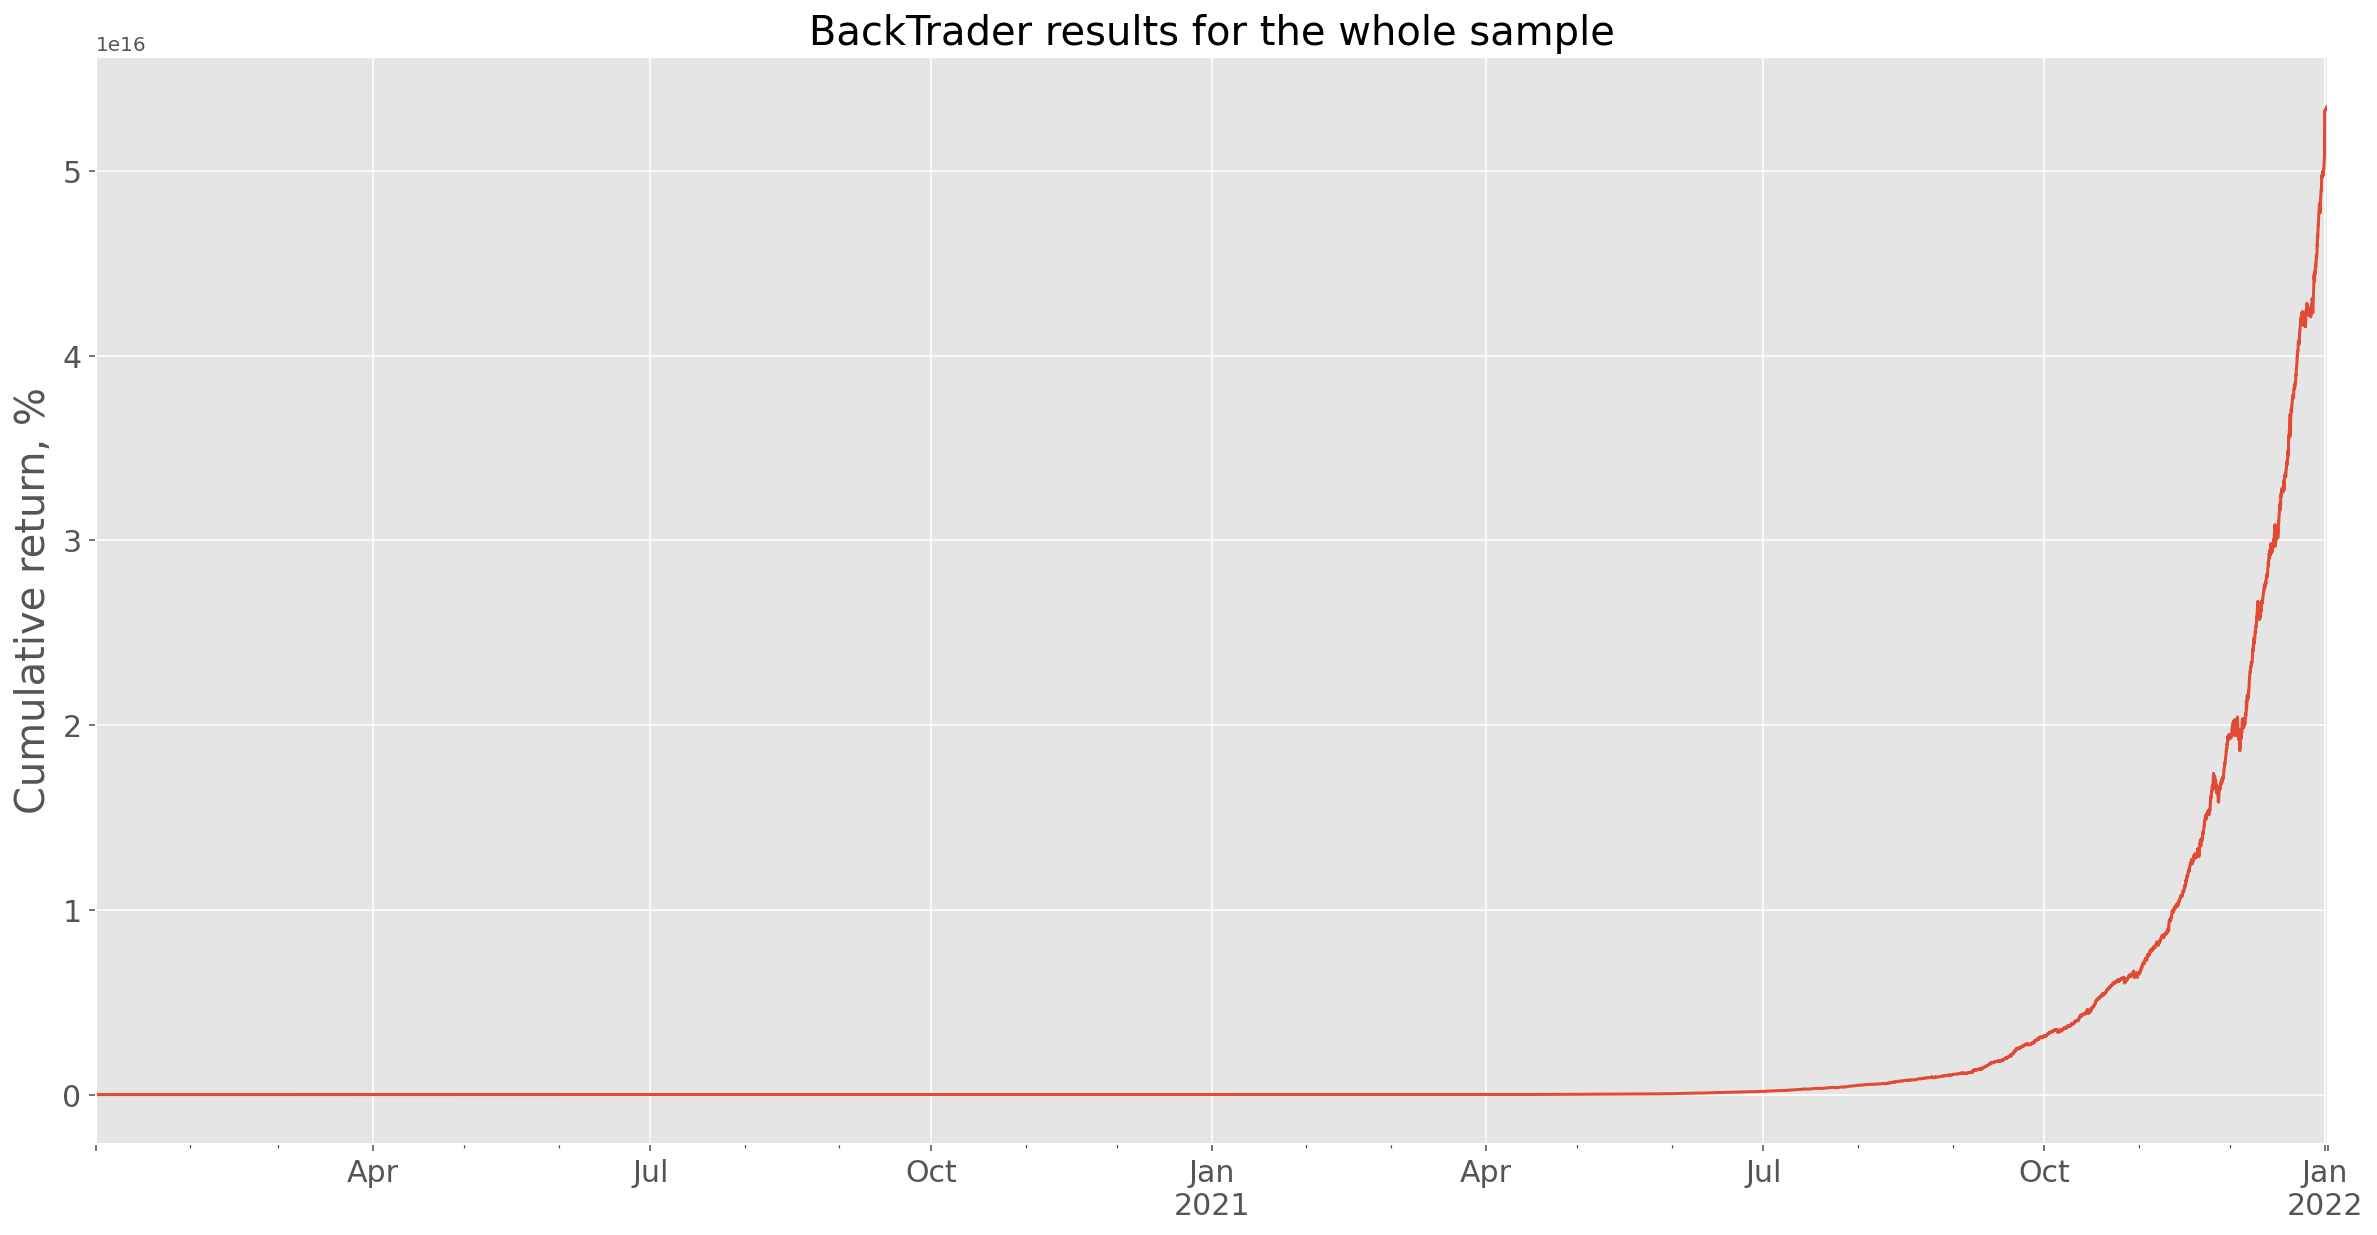

In [28]:
bt_cum_ret = (np.cumproduct(Series(returns1h) + 1) - 1) * 100
bt_cum_ret.plot(figsize=(20, 10))
plt.xlabel('')
plt.ylabel('Cumulative return, %', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('BackTrader results for the whole sample', size=20)
plt.show()